# scRNAseq Data Analysis - from QC to Manual Annotation

 * PART 0. Reproducibility
*PART 1. Basic quality control and filtering.
*PART 2. Normalization and dimensionality reduction
*PART 3. Normalization and careful clustering of the cleaned dataset
*PART 4. Differential expression and marker selection
* **PART 5. Gen Set Enrichment Analysis**
* **PART 6.Automatic cell annotattion using scoreCT**
*Saving

# Setup

This notebook should introduce you to some typical tasks, using Scanpy eco-system.(https://scanpy.readthedocs.io/en/stable/tutorials.html).


Let's import the necessary packages and read in the Cellranger-formatted data folder output.

In [ ]:
import scanpy as sc
import numpy as np
import re
import os
import pandas as pd
import seaborn as sb
import matplotlib
import scipy.sparse as sp
from scipy.sparse import issparse
import anndata2ri

import matplotlib as mpl
from scipy import stats as scistats
import matplotlib.pyplot as pl
import scanpy.external as sce
from matplotlib import colors
import bbknn
from pathlib import Path
from ipywidgets import interactive

sc._settings.ScanpyConfig.n_jobs=8

pl.rcParams['pdf.fonttype'] = 'truetype'
sc.set_figure_params(vector_friendly=False,dpi_save=300,transparent=True)
pl.rcParams['lines.linewidth'] = 0.1
sc.set_figure_params(color_map='viridis')
colorsComb = np.vstack([pl.cm.Reds(np.linspace(0, 1, 10)), pl.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

import muon as mu
from muon import prot as pt

%matplotlib inline
import panel as pn
#pn.extension(sizing_mode="stretch_width", comms='colab')
pn.extension( comms='colab')


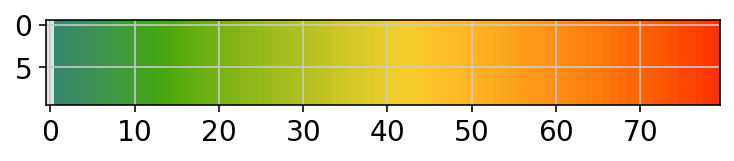

In [ ]:
import colorcet as cc

xs, _ = np.meshgrid(np.linspace(0, 1, 80), np.linspace(0, 1, 10))
colorsComb = np.vstack([pl.cm.Greys_r(np.linspace(0.8,0.1, 1)), cc.cm.rainbow_bgyr_35_85_c72(np.linspace(0.2,1, 100))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
pl.imshow(xs, cmap=mymap);  # use tab completion to choose

In [ ]:
# add extra code to the path
import sys
sys.path.append('/content/sctoolkit/sctoolkit/')
from proportions import *

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


# PART 0. Reproducibility

In [ ]:
%load_ext watermark
%watermark
%watermark --iversions -v -m -p numpy,scipy,sklearn,anndata,scanpy,muon,anndata2ri,rpy2

Last updated: 2022-07-10T17:37:11.703249+00:00

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.13.0-1031-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

numpy     : 1.21.6
scipy     : 1.8.0
sklearn   : 0.0
anndata   : 0.7.8
scanpy    : 1.9.1
muon      : 0.1.2
anndata2ri: 1.1
rpy2      : 3.5.1

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.13.0-1031-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

re        : 2.2.1
logging   : 0.5.1.2
scanpy    : 1.9.1
colorcet  : 3.0.0
panel     : 0.13.1
scipy     : 1.8.0
sys       : 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:59) 
[GCC 10.3.0]
bbknn     : 1.5.1
muon      : 0.1.2
matplotlib: 3.5.2
anndata2ri: 1.1
seaborn   : 0.11.2
numpy     : 1.21.6
pandas  

# PART 1. Basic quality control and filtering.

# Setup data directory

In [ ]:
data_dir = '/home/jovyan/work/shared-data/Multiome_Results/Heart/'

In [ ]:
%cd /home/jovyan/work/

/home/jovyan/work


In [ ]:
#Change XXX to sample name
#folder='/content/'

yourname='meethila'

samplename='Heart'
random_state=42

import os

if not os.path.exists('./figures/'):
    os.makedirs('./figures/')

# Setup WD

shared-data/Multiome_Results/Brain/filtered_feature_bc_matrix/matrix.mtx.gz# import data as H5AD


Reading the matrix with cache enabled helps save time on I/O operations, which is particularly relevant for bigger datasets.

In [ ]:
adata = sc.read_10x_mtx(data_dir + "/filtered_feature_bc_matrix/",cache = True)
adata


AnnData object with n_obs × n_vars = 2760 × 32285
    var: 'gene_ids', 'feature_types'

Let's make sure all gene names are unique. This is done with var_names_make_unique function.

In [ ]:
adata.var_names_make_unique()
adata
adata.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

We can also explore the newly created AnnData object. The obs field will contain all of per-cell metadata; for now, it only has the barcodes.

In [ ]:
adata.obs.head()

Empty DataFrame
Columns: []
Index: [AAACAGCCAAGGATTA-1, AAACAGCCAATAGTCT-1, AAACAGCCACACCAAC-1, AAACAGCCAGGAACAT-1, AAACAGCCAGGTCCTG-1]

Lets add some metadata

In [ ]:
adata.obs['sample']=[samplename]*adata.n_obs
adata.obs['group']=['mouse_heart']*adata.n_obs

In [ ]:
adata.obs.head()

sample        group
AAACAGCCAAGGATTA-1  Heart  mouse_heart
AAACAGCCAATAGTCT-1  Heart  mouse_heart
AAACAGCCACACCAAC-1  Heart  mouse_heart
AAACAGCCAGGAACAT-1  Heart  mouse_heart
AAACAGCCAGGTCCTG-1  Heart  mouse_heart

Let's remove all genes expressed in fewer than 5 cells:

In [ ]:
sc.pp.filter_genes(adata, min_cells=5)
adata

AnnData object with n_obs × n_vars = 2760 × 16339
    obs: 'sample', 'group'
    var: 'gene_ids', 'feature_types', 'n_cells'

# Filter doublets with scrublet

For filter doublets with scrublet, we would need the expected doublet formation rate. These values can be found [here](https://uofuhealth.utah.edu/huntsman/shared-resources/gba/htg/single-cell/genomics-10x.php). Since our dataset has approximately 5,000 (recovered) cells, we take the 2.3%.

Calling the main function, `scrub_doublets`, calculates a score for each cell, and assigns the binary (doublet/singlet) prediction based on this score. We can store this data as metadata in the `adata` object.

In [ ]:
sce.pp.scrublet(adata,expected_doublet_rate = 0.03,threshold=None)

/opt/conda/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.


Automatically set threshold at doublet score = 0.32
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 32.0%
Overall doublet rate:
	Expected   = 3.0%
	Estimated  = 0.6%


The following histogram is an important diagnostic plot. Doublet score threshold should separate the two shoulders of the bimodal distribution. If this is not so, adjust the threshold accordingly.

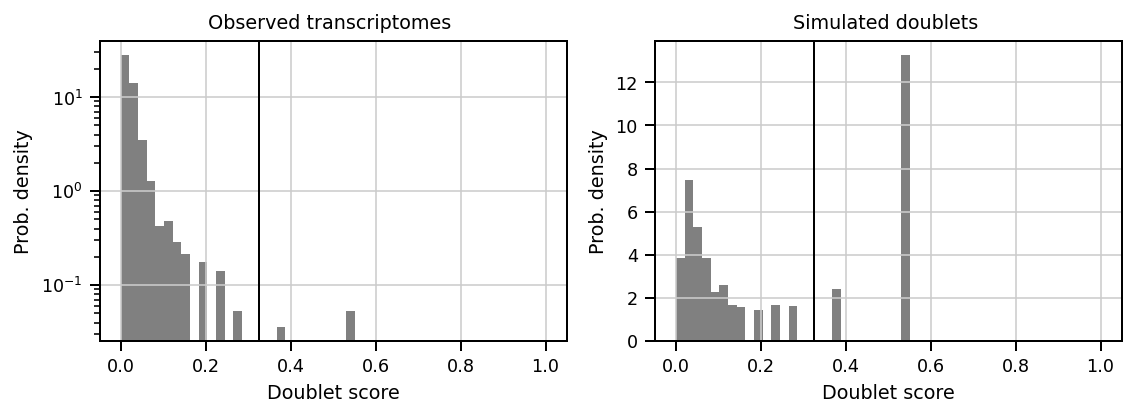

In [ ]:
sb.set_context('paper')
savefig=samplename + '_7_QC_doublets.pdf'
sce.pl.scrublet_score_distribution(adata,save=savefig)

In [ ]:
adata.obs

sample        group  doublet_score  predicted_doublet
AAACAGCCAAGGATTA-1  Heart  mouse_heart       0.012494              False
AAACAGCCAATAGTCT-1  Heart  mouse_heart       0.006980              False
AAACAGCCACACCAAC-1  Heart  mouse_heart       0.034826              False
AAACAGCCAGGAACAT-1  Heart  mouse_heart       0.012494              False
AAACAGCCAGGTCCTG-1  Heart  mouse_heart       0.012494              False
...                   ...          ...            ...                ...
TTTGTCTAGAACAAGT-1  Heart  mouse_heart       0.036909              False
TTTGTGAAGGCGGATG-1  Heart  mouse_heart       0.006980              False
TTTGTTGGTAATGGAA-1  Heart  mouse_heart       0.021550              False
TTTGTTGGTGAAACAA-1  Heart  mouse_heart       0.023860              False
TTTGTTGGTTAATCGG-1  Heart  mouse_heart       0.019495              False

[2760 rows x 4 columns]

Let's calculate some information about mitochondrial genes, which is important for quality control (high MT gene content usually means dead cells). We also will calculate the fraction of ribosomal proteins which can be used as another useful identifier of cell state. 

In [ ]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

# compute qc metrics

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['rb'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal proteins as 'rb'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

adata

AnnData object with n_obs × n_vars = 2760 × 16339
    obs: 'sample', 'group', 'doublet_score', 'predicted_doublet', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

# Helper plots for determining gene and count threshold values

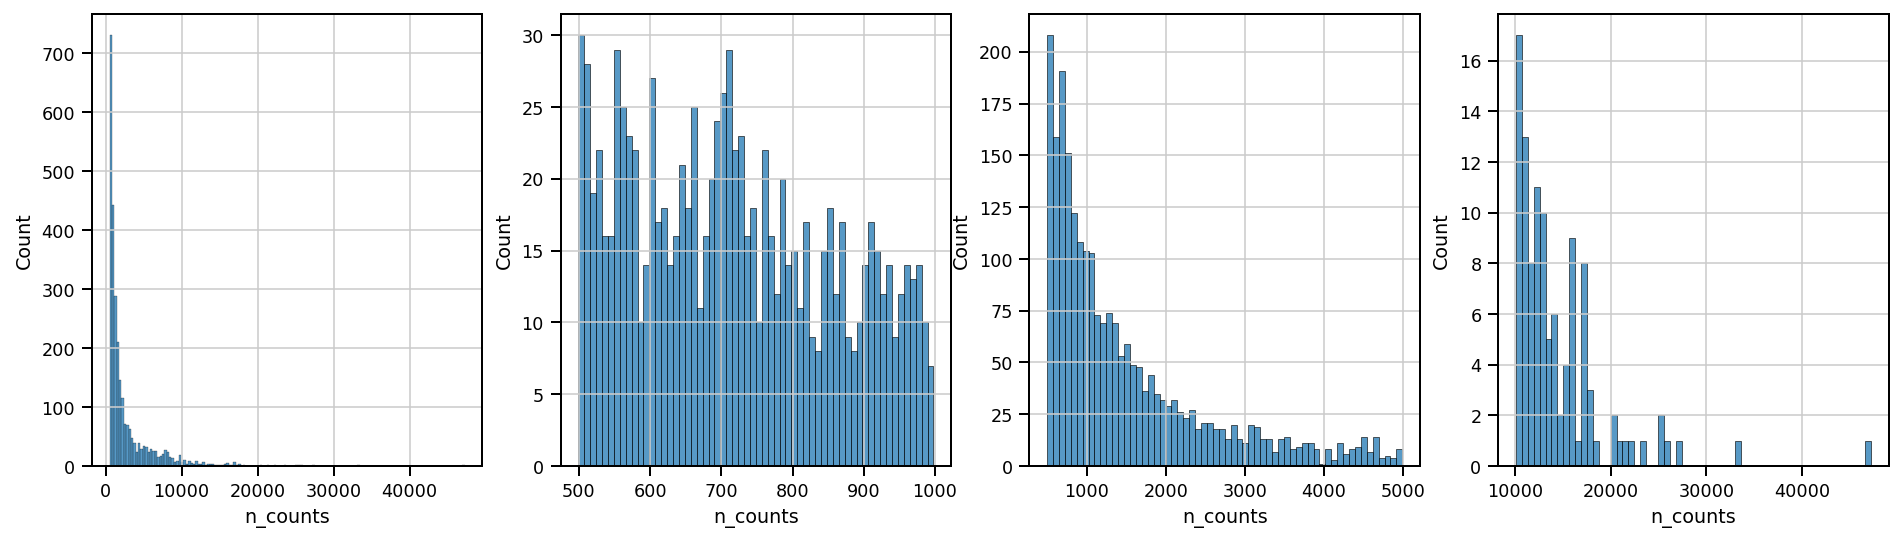

In [ ]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(adata.obs['n_counts'], kde=False, ax=ax1,)
ax2_dict =  sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']<1000], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']<5000], kde=False, bins=60, ax=ax3,)
ax4_dict = sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60, ax=ax4, )
savefig='figures/'+samplename + '_1_QC_counts_filtering.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

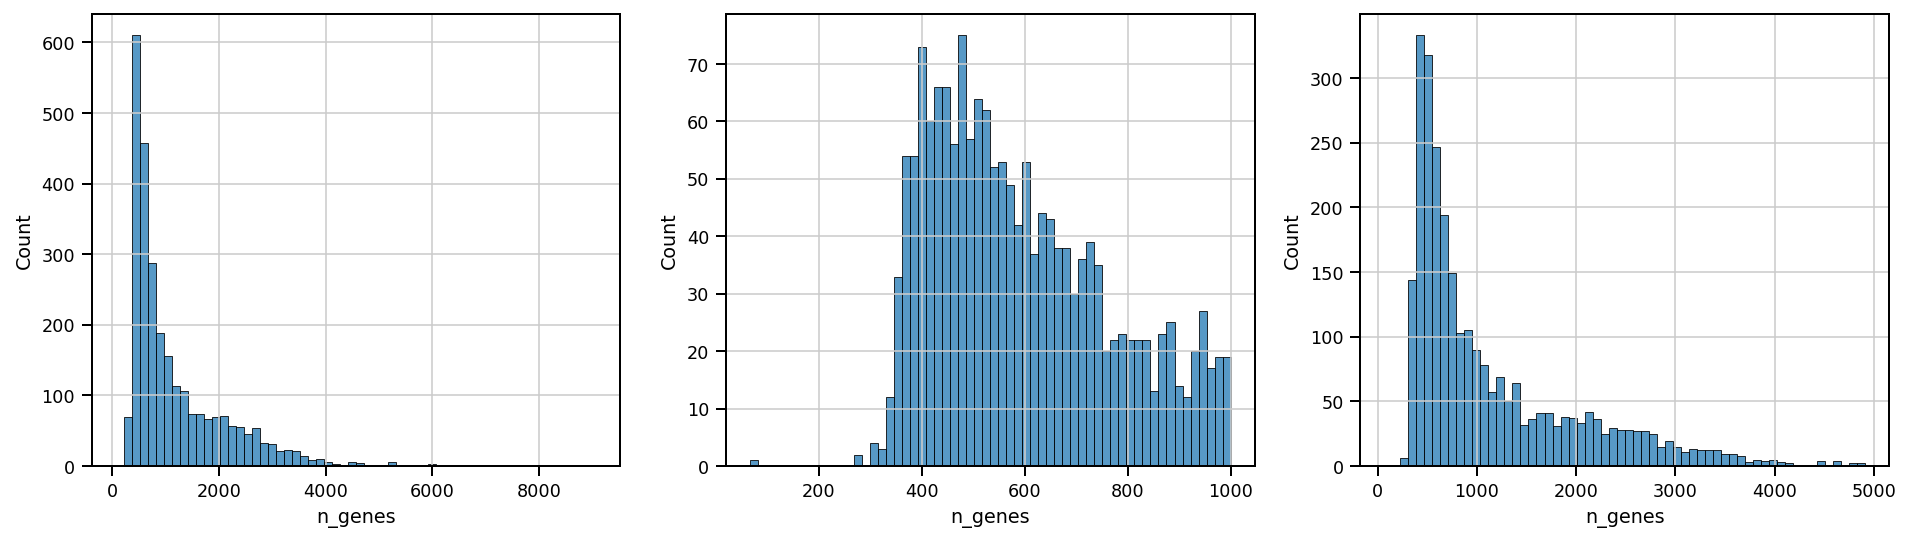

In [ ]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(adata.obs['n_genes'], kde=False, bins=60, ax=ax1,)
ax2_dict =  sb.histplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(adata.obs['n_genes'][adata.obs['n_genes']<5000], kde=False, bins=60, ax=ax3,)
savefig='figures/'+samplename + '_2_QC_gene_filtering.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

Plot correlations and make sure that high mitochondrial content corresponds with low total counts (dead cells), and that total counts have strong positive correlation with the number of expressed genes:

... storing 'sample' as categorical
... storing 'group' as categorical
... storing 'feature_types' as categorical


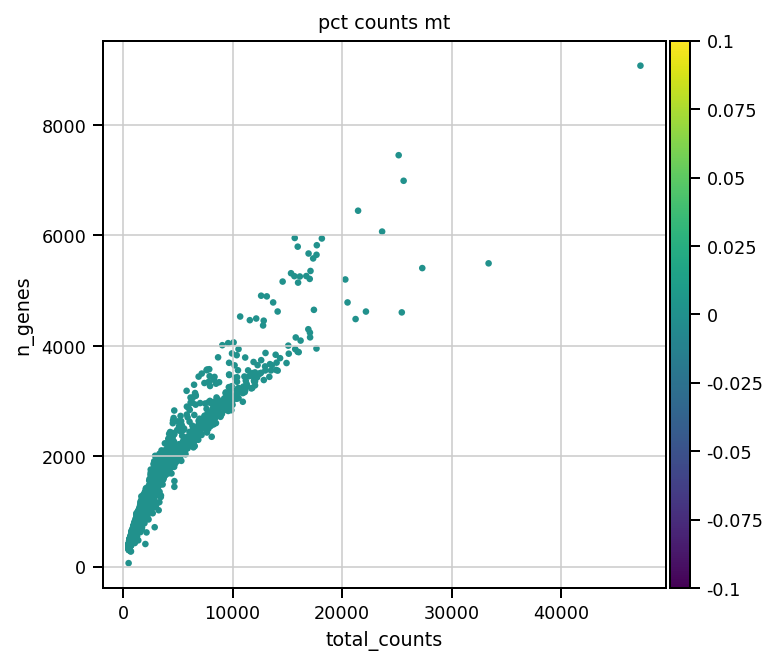

In [ ]:
# plot percentage of mitochondtial genes versus count depth and n_genes
sb.set_context('paper')
pl.rcParams['figure.figsize']=(5,5) #rescale figures
savefig=samplename + '_4_QC_saturationplot.pdf'
sc.pl.scatter(adata, x='total_counts', y='n_genes', color='pct_counts_mt',save=savefig)

Filter outliers cells with >150,000 couts

In [ ]:
sc.pp.filter_cells(adata, max_counts = 150000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

Number of cells after max count filter: 2760


High ribosomal protein content can correlate inversly with  with MT, and may contain biological information.( Do not apply to snRNASeq. Why?)

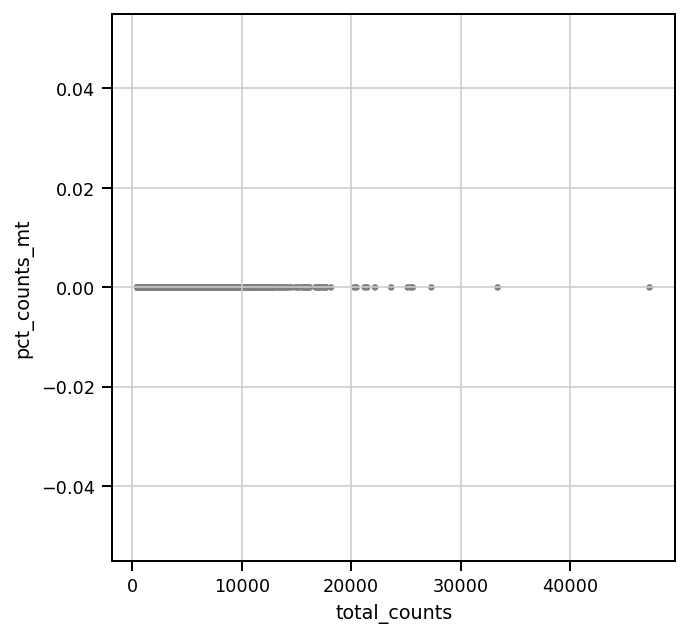

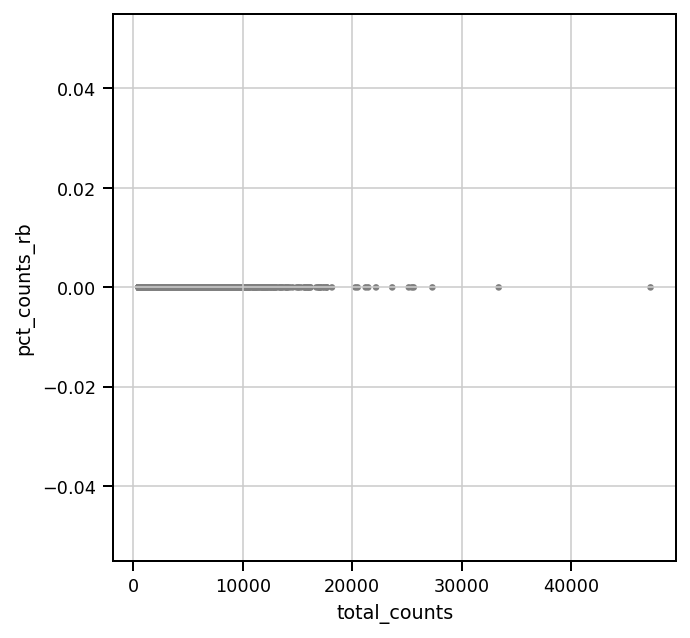

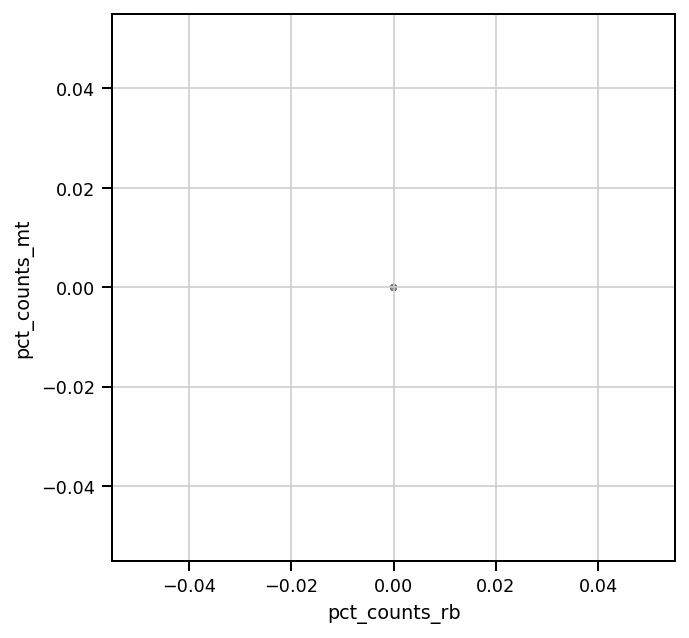

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(5,5) #rescale figures
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_rb')
sc.pl.scatter(adata, x='pct_counts_rb', y='pct_counts_mt')

A violin plot of the computed quality measures can help us analyze the dataset in general and make decisions about cutoffs.

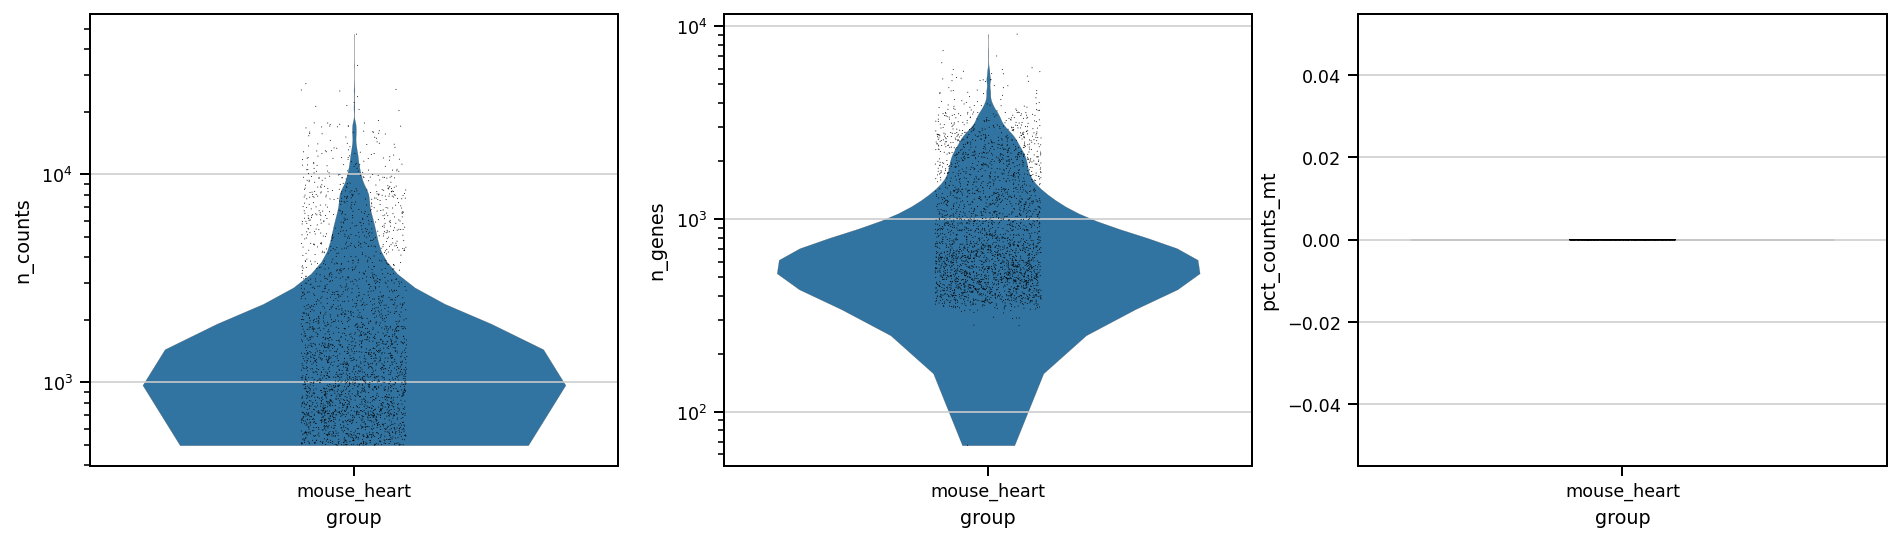

In [ ]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sc.pl.violin(adata, 'n_counts', groupby='group', size=0.5, log=True, cut=0, ax=ax1, show=False)
ax2_dict =  sc.pl.violin(adata, 'n_genes', groupby='group', size=0.5, log=True, cut=0, ax=ax2, show=False)
ax3_dict = sc.pl.violin(adata, 'pct_counts_mt', groupby='group',size=0.5, ax=ax3, show=False,)
savefig='figures/'+samplename + '_5_QC_violin_plots.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

Let's show those genes that yield the highest fraction of counts in each single cell, across all cells.

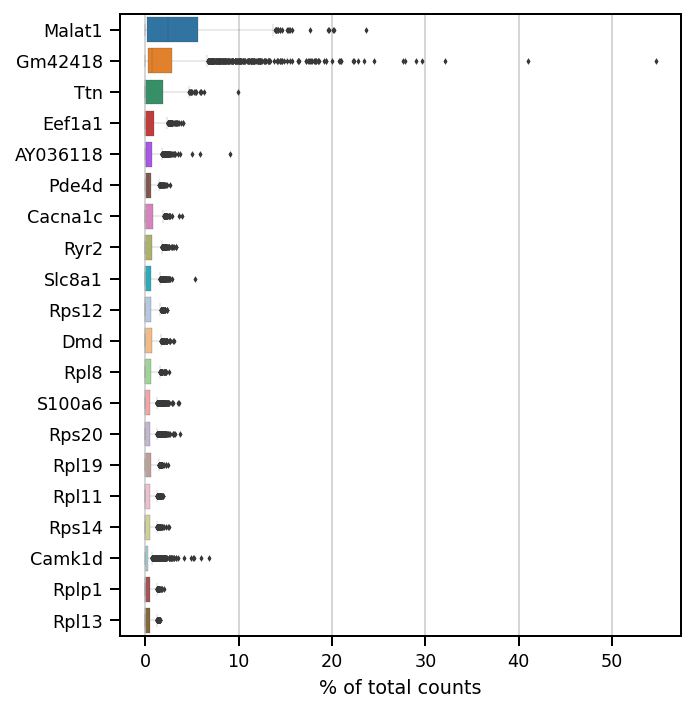

In [ ]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
savefig='_'+samplename + '_6_QC_highest_expr_genes.pdf'
sc.pl.highest_expr_genes(adata, n_top=20,save=savefig,)

In [ ]:
print(adata.obs['group'].value_counts())

mouse_heart    2760
Name: group, dtype: int64


In [ ]:
adata.obs['n_counts'].sum()/adata.obs['group'].value_counts()

mouse_heart    2673.837681
Name: group, dtype: float64

In [ ]:
adata.obs['n_counts'].sum()

7379792.0

# Interactive filtering

In [ ]:
def h(counts=400, genes=400,mito=15):
    conditions = [(adata.obs['predicted_doublet'] == True),(adata.obs['n_genes_by_counts'] < counts),(adata.obs['n_genes'] < genes),(adata.obs['pct_counts_mt'] >mito),(adata.obs['pct_counts_mt'] <= mito) & (adata.obs['n_genes_by_counts'] >= counts) & (adata.obs['n_genes'] >= genes)& (adata.obs['predicted_doublet'] != True)]
    values = ['Doublet', 'Low_nFeature', 'Low_ngenes','High_MT', 'Passing']
    adata.obs['QC'] = np.select(conditions, values)
    adata.obs['QC'] = adata.obs['QC'].astype('category')

    new_df1=pd.DataFrame(adata.obs['QC'].value_counts()).reset_index()
    p=sb.barplot(x='index',y='QC',data=new_df1,color='sandybrown')
    show_values(p)


interactive_plot = interactive(h, counts=(0, 2000,20), genes=(0, 2000,20), mito=(0, 100, 1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=400, description='counts', max=2000, step=20), IntSlider(value=400, desc…

In [ ]:
adata.obs['QC'].value_counts()

Passing         2558
Low_nFeature     197
Doublet            5
Name: QC, dtype: int64

## Plot QC for cells that pass tentative thresholds

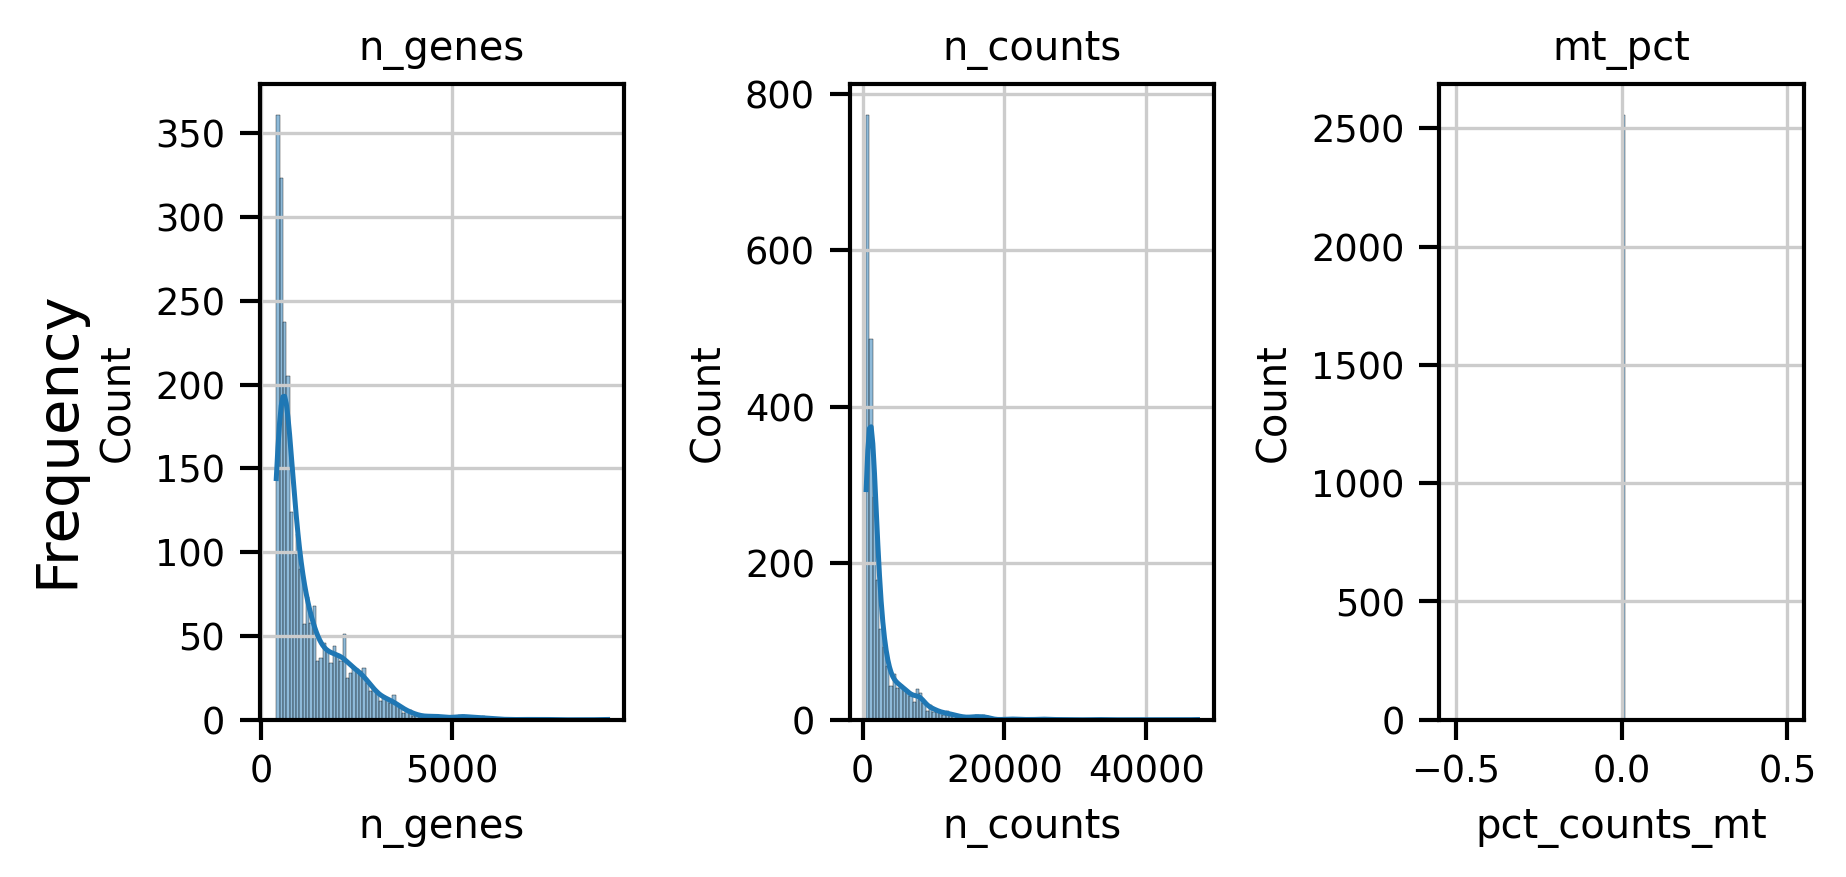

In [ ]:

sb.set_context('paper')


fig, (ax1, ax2, ax3) = pl.subplots(1, 3, figsize=(6, 3), dpi=150, sharey=False)
adata.obs['n_genes']

sb.histplot( adata[adata.obs['QC'] == 'Passing'].obs['n_genes'], ax=ax1, kde=True, bins=100)
sb.histplot( adata[adata.obs['QC'] == 'Passing'].obs['n_counts'], ax=ax2, kde=True, bins=100)
sb.histplot(adata[adata.obs['QC'] == 'Passing'].obs['pct_counts_mt'], ax=ax3, kde=True, bins=100)

ax1.title.set_text('n_genes')
ax2.title.set_text('n_counts')
ax3.title.set_text('mt_pct')

fig.text(0.00, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()
savefig='figures/'+samplename + '_3_QC_filtering_postfilter.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

# PART 2. Normalization and dimensionality reduction.

Squre root of total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells. The data are also log-transformed with a pseudocount of 1. Transformed data is stored in 'sqrt_norm' layer

In [ ]:
adata.layers["raw"] = adata.X 
adata.raw=adata
adata.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata, inplace=False)["X"])

pearson residuals normalization used for Dimention reduction, stored in normalized

The comand will :
 * Calculate pearson residuals for each gene 
 * Identify highly-variable genes to prioritize in further analysis.
 * Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [ ]:
sc.experimental.pp.recipe_pearson_residuals(adata,n_top_genes=3000,n_comps=100,random_state=42,inplace=True)
adata.layers["normalized"]=adata.X

adata

AnnData object with n_obs × n_vars = 2760 × 16339
    obs: 'sample', 'group', 'doublet_score', 'predicted_doublet', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'QC'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'scrublet', 'group_colors', 'hvg', 'pca', 'pearson_residuals_normalization'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw', 'sqrt_norm', 'normalized'

Plot the highly variable genes, after the normalization.

In [ ]:
adata

AnnData object with n_obs × n_vars = 2760 × 16339
    obs: 'sample', 'group', 'doublet_score', 'predicted_doublet', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'QC'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'scrublet', 'group_colors', 'hvg', 'pca', 'pearson_residuals_normalization'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw', 'sqrt_norm', 'normalized'

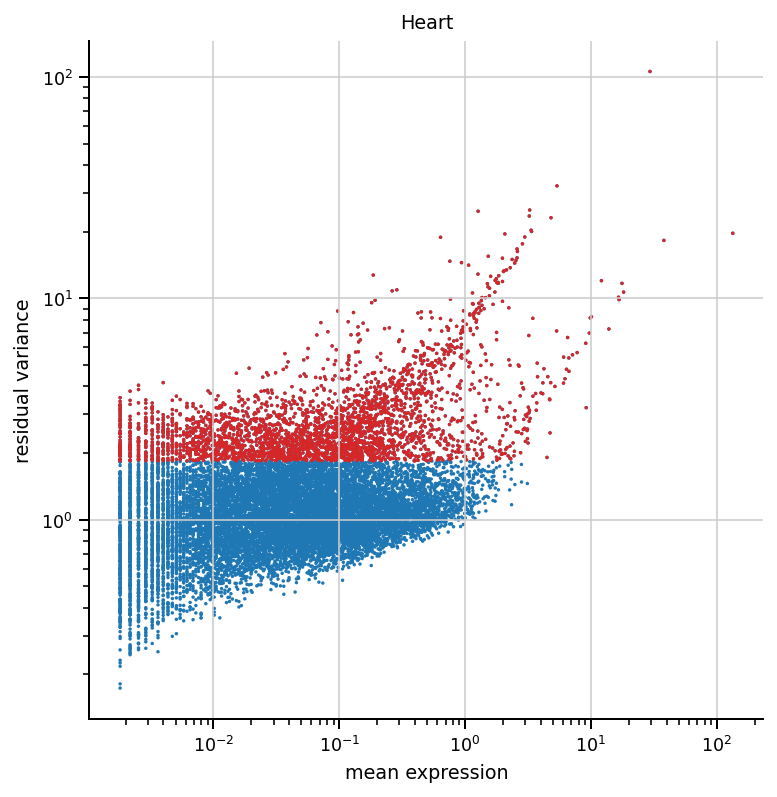

In [ ]:
#markers = ["IL7R","LYZ","CD14","MS4A1","CD8A","GNLY","NKG7","FCGR3A","MS4A7","FCER1A","CST3","PPBP",]
markers = ["Th"]
hvgs = adata.var["highly_variable"]
fig, ax = plt.subplots(figsize=(6, 6))
pl.scatter(
        adata.var["mean_counts"], adata.var["residual_variances"], s=3, edgecolor="none"
    )
pl.scatter(
        adata.var["mean_counts"][hvgs],
        adata.var["residual_variances"][hvgs],
        c="tab:red",
        label="selected genes",
        s=3,
        edgecolor="none",
    )
pl.scatter(
        adata.var["mean_counts"][np.isin(adata.var_names, markers)],
        adata.var["residual_variances"][np.isin(adata.var_names, markers)],
        c="k",
        label="known marker genes",
        s=10,
        edgecolor="black",
    )
ax.set_xscale("log")
ax.set_xlabel("mean expression")
ax.set_yscale("log")
ax.set_ylabel("residual variance")
ax.set_title(samplename)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# cellcycle score

 Let's calculate cell cycle scores, as described [here](https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb). 

It is important to note that cell cycle analysis has to be done after normalization 

In [ ]:
s_genes = ['Mcm5','Pcna','Tyms','Fen1','Mcm7','Mcm4','Rrm1','Ung','Gins2','Mcm6','Cdca7','Dtl','Prim1',
           'Uhrf1','Cenpu','Hells','Rfc2','Polr1b','Nasp','Rad51ap1','Gmnn','Wdr76','Slbp','Ccne2','Ubr7',
           'Pold3','Msh2','Atad2','Rad51','Rrm2','Cdc45','Cdc6','Exo1','Tipin','Dscc1','Blm','Casp8ap2',
           'Usp1','Clspn','Pola1','Chaf1b','Mrpl36','E2f8']
g2m_genes = ['Hmgb2','Cdk1','Nusap1','Ube2c','Birc5','Tpx2','Top2a','Ndc80','Cks2','Nuf2','Cks1b',
             'Mki67','Tmpo','Cenpf','Tacc3','Pimreg','Smc4','Ccnb2','Ckap2l','Ckap2','Aurkb','Bub1',
             'Kif11','Anp32e','Tubb4b','Gtse1','Kif20b','Hjurp','Cdca3','Jpt1','Cdc20','Ttk','Cdc25c',
             'Kif2c','Rangap1','Ncapd2','Dlgap5','Cdca2','Cdca8','Ect2','Kif23','Hmmr','Aurka','Psrc1',
             'Anln','Lbr','Ckap5','Cenpe','Ctcf','Nek2','G2e3','Gas2l3','Cbx5','Cenpa']

cell_cycle_genes = s_genes + g2m_genes
display(len(s_genes))
display(len(g2m_genes))
display(len(cell_cycle_genes))

43

54

97

In [ ]:
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
len(cell_cycle_genes)

96

In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


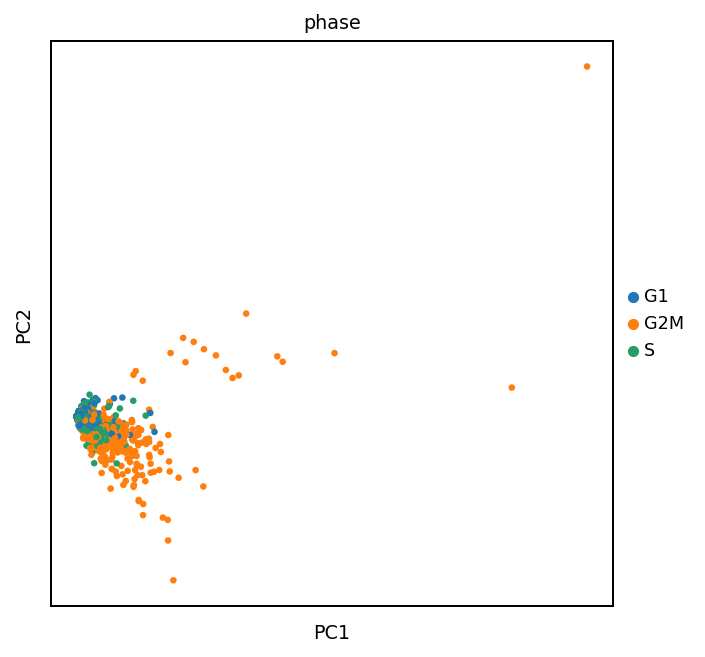

In [ ]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

# PCA (Ploting only)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

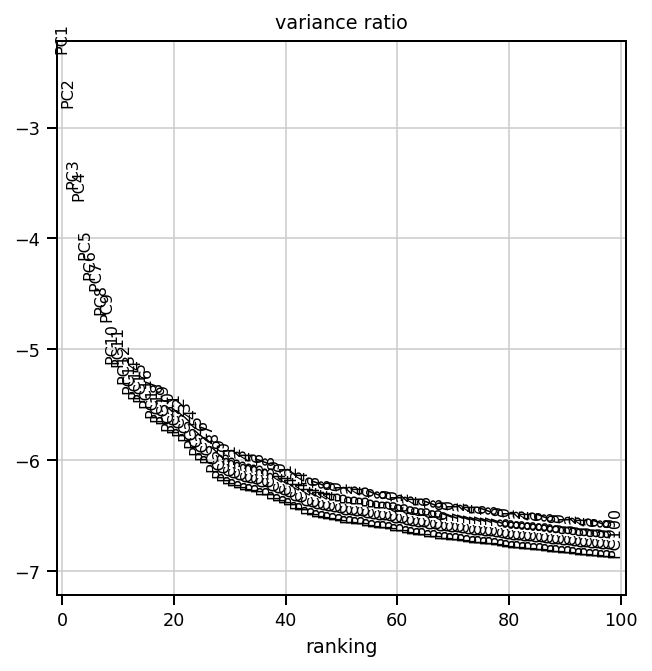

In [ ]:
#sc.pp.pca(adata, n_comps = 100, use_highly_variable =False, svd_solver = "arpack")
sc.pl.pca_variance_ratio(adata, n_pcs = 100,log=True)

UMAP and tSNE are popular methods used for dimensionality reduction and visualisation of very large datasets. UMAP is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories.

Plot the data with UMAP, with coloring according to clustering. Some larger clusters are clearly identifiable as cell populations. Other smaller clusters can be attributed to doublets, cell cycle artefacts, etc.

... storing 'phase' as categorical


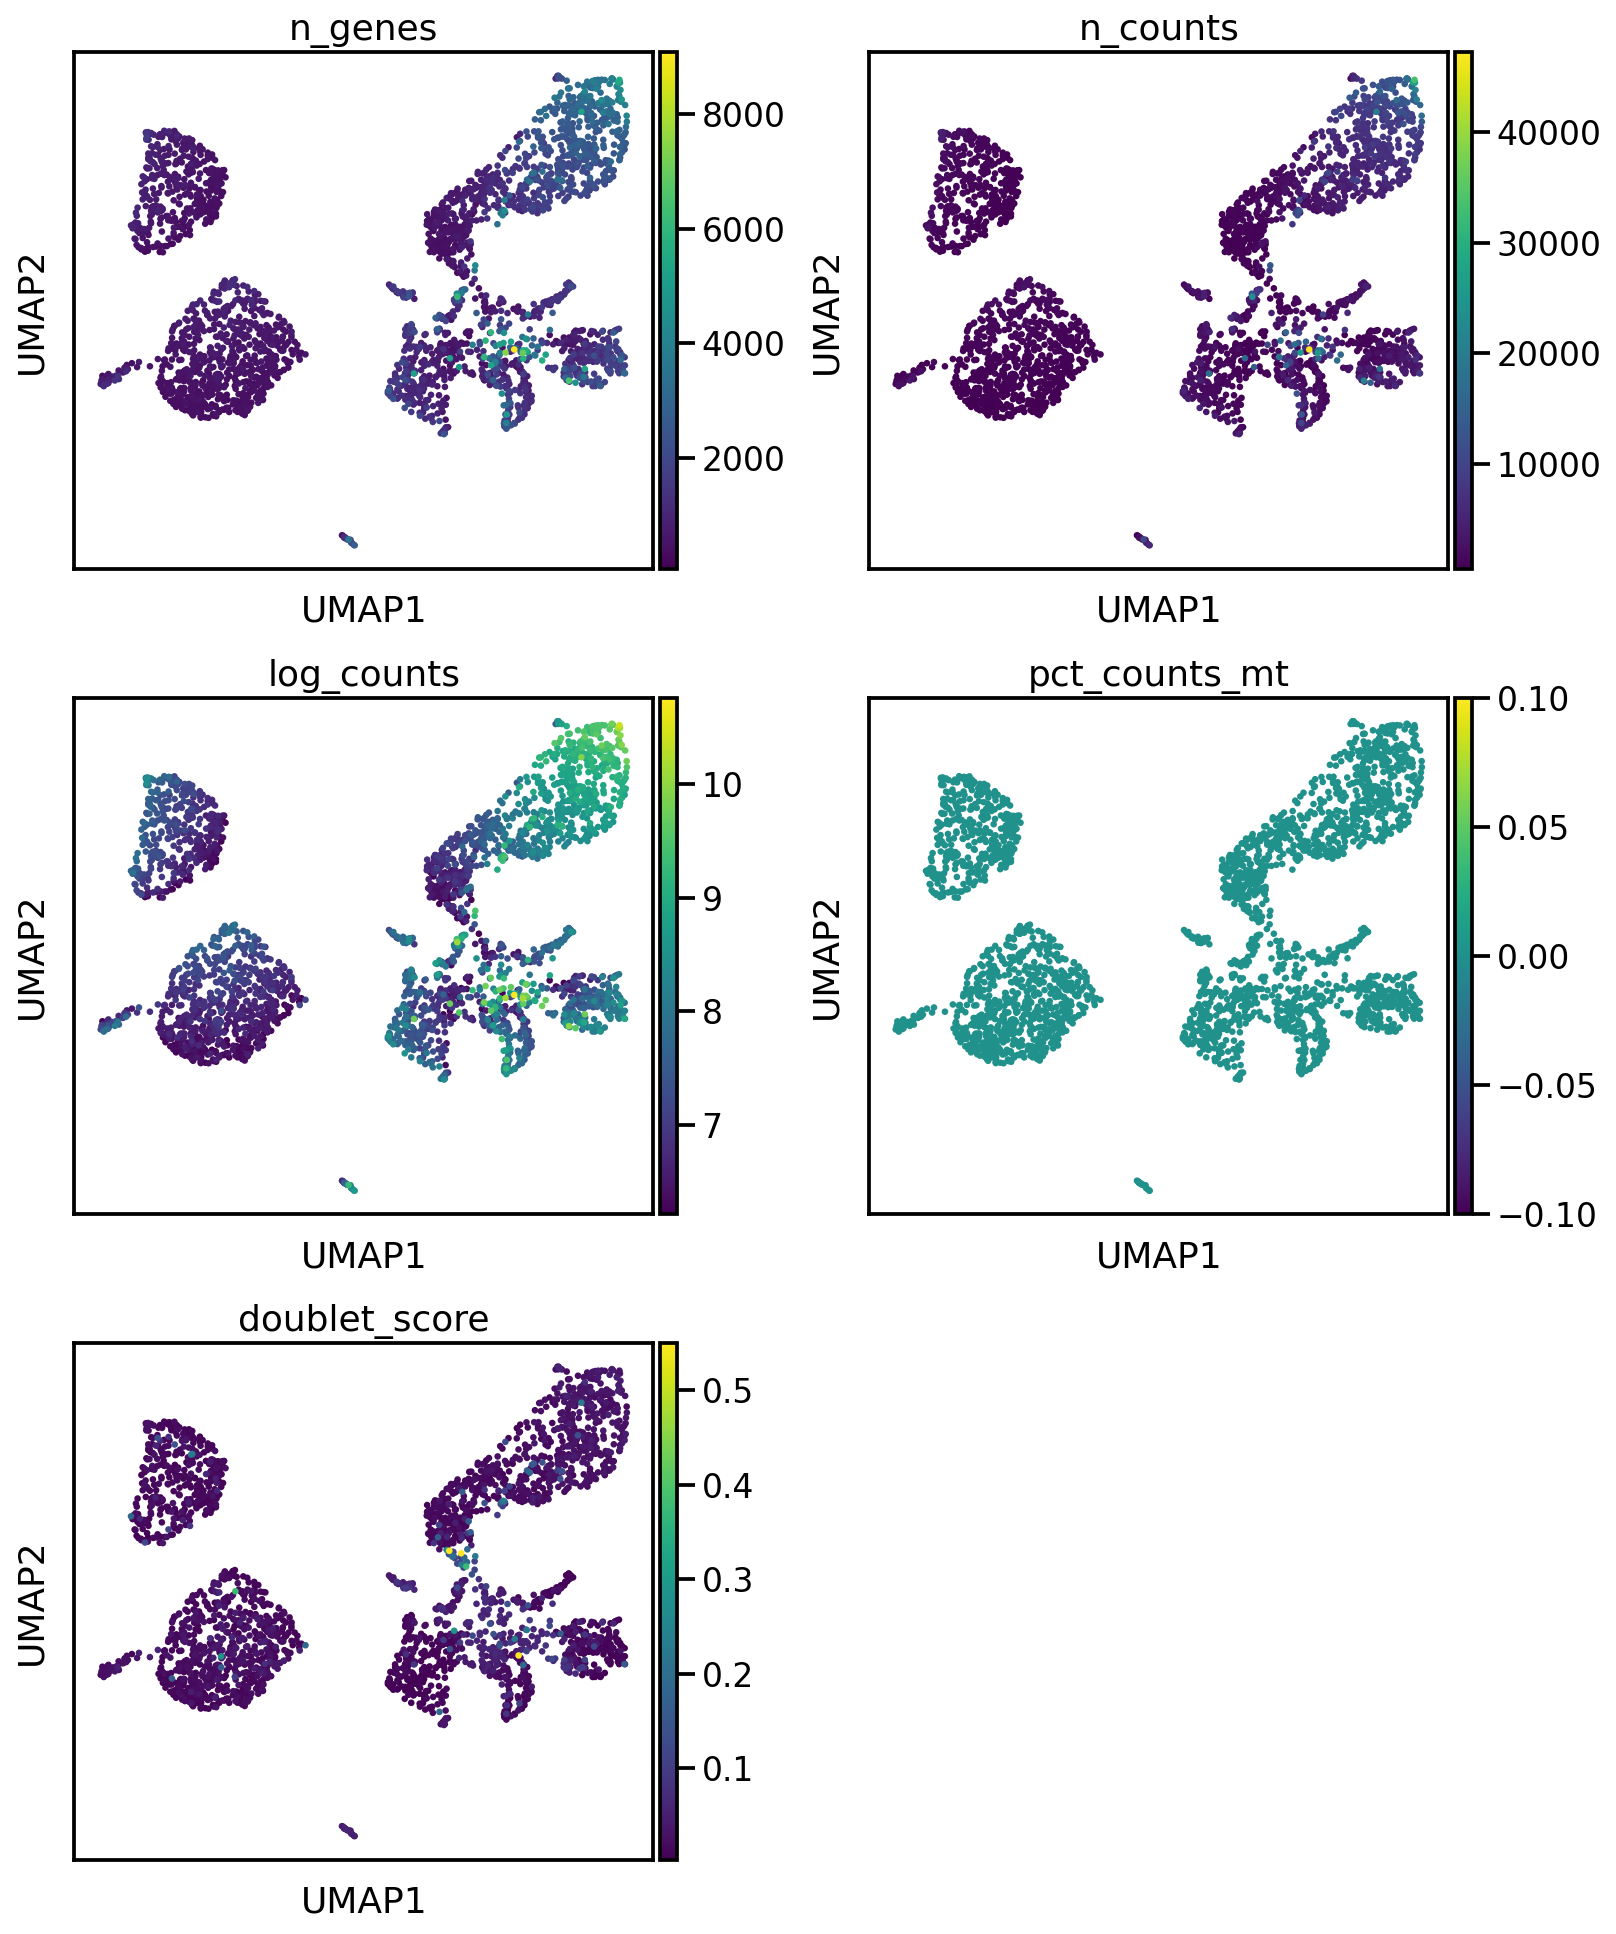

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
sc.pp.neighbors(adata, n_pcs=30,n_neighbors=10,random_state=42)

genes_to_plot = ['n_genes','n_counts','log_counts','pct_counts_mt','doublet_score']
sc.tl.umap(adata)
savefig=samplename+"_4_QC_doublets_vst_mito.pdf"
sc.pl.umap(adata, color = genes_to_plot,ncols=2,wspace=0.25, save=savefig)

Let's remove the cells that did not pass QC and compare plots. We can now see much more defined clusters. 

In [ ]:
adata

AnnData object with n_obs × n_vars = 2760 × 16339
    obs: 'sample', 'group', 'doublet_score', 'predicted_doublet', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'QC', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'scrublet', 'group_colors', 'hvg', 'pca', 'pearson_residuals_normalization', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'sqrt_norm', 'normalized'
    obsp: 'distances', 'connectivities'

In [ ]:
adata = adata[adata.obs['QC'] == 'Passing']
adata

View of AnnData object with n_obs × n_vars = 2558 × 16339
    obs: 'sample', 'group', 'doublet_score', 'predicted_doublet', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'QC', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'scrublet', 'group_colors', 'hvg', 'pca', 'pearson_residuals_normalization', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'sqrt_norm', 'normalized'
    obsp: 'distances', 'connectivities'

Our filtered dataset now contains 2036 cells, only 13 cells were removed!

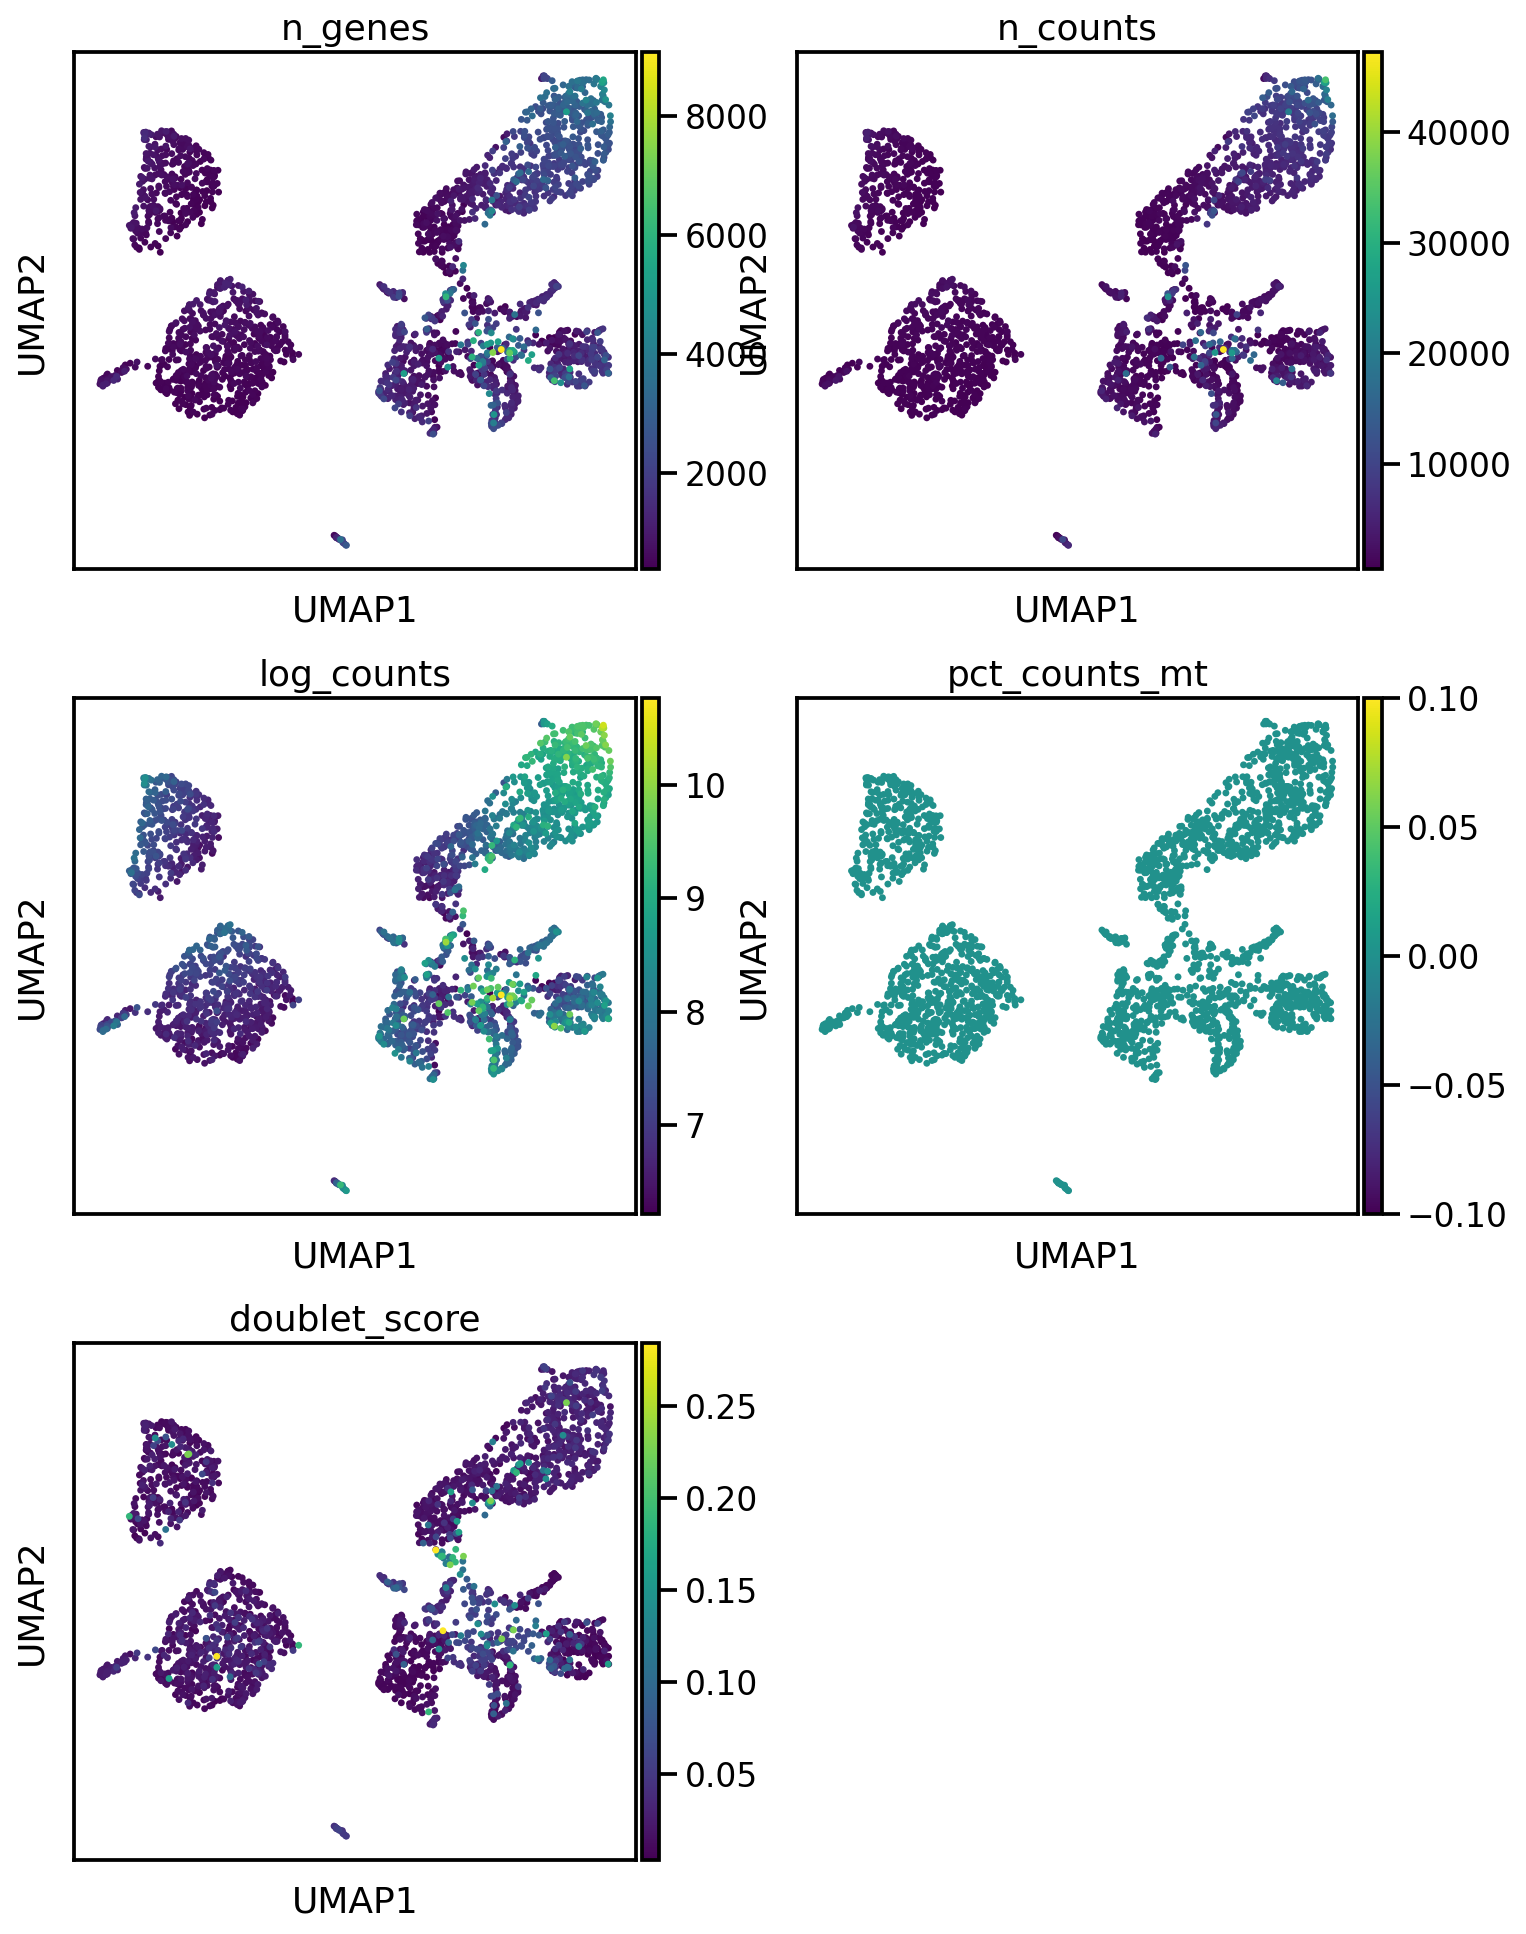

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
savefig=samplename+"_4_QC_doublets_vst_mito.pdf"
sc.pl.umap(adata, color = genes_to_plot,ncols=2,layer='counts',save=savefig)

# PART 3. Normalization and careful clustering of the cleaned dataset.

Let's restart our analysis from the counts matrix again

In [ ]:
adata.X=adata.layers['raw']

Let's redo HVG, PCA, UMAP, and clustering analysis, since now we have QC-filtered cells.

In [ ]:
#HVG
sc.experimental.pp.highly_variable_genes(adata, flavor="pearson_residuals", n_top_genes=2000)

/opt/conda/lib/python3.9/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:67: UserWarning: Received a view of an AnnData. Making a copy.


In [ ]:
# Nomalization
sc.experimental.pp.normalize_pearson_residuals(adata,inplace=True)
adata.layers["normalized"]=adata.X

In [ ]:
#PCA
sc.pp.pca(adata, n_comps=30,random_state=42)

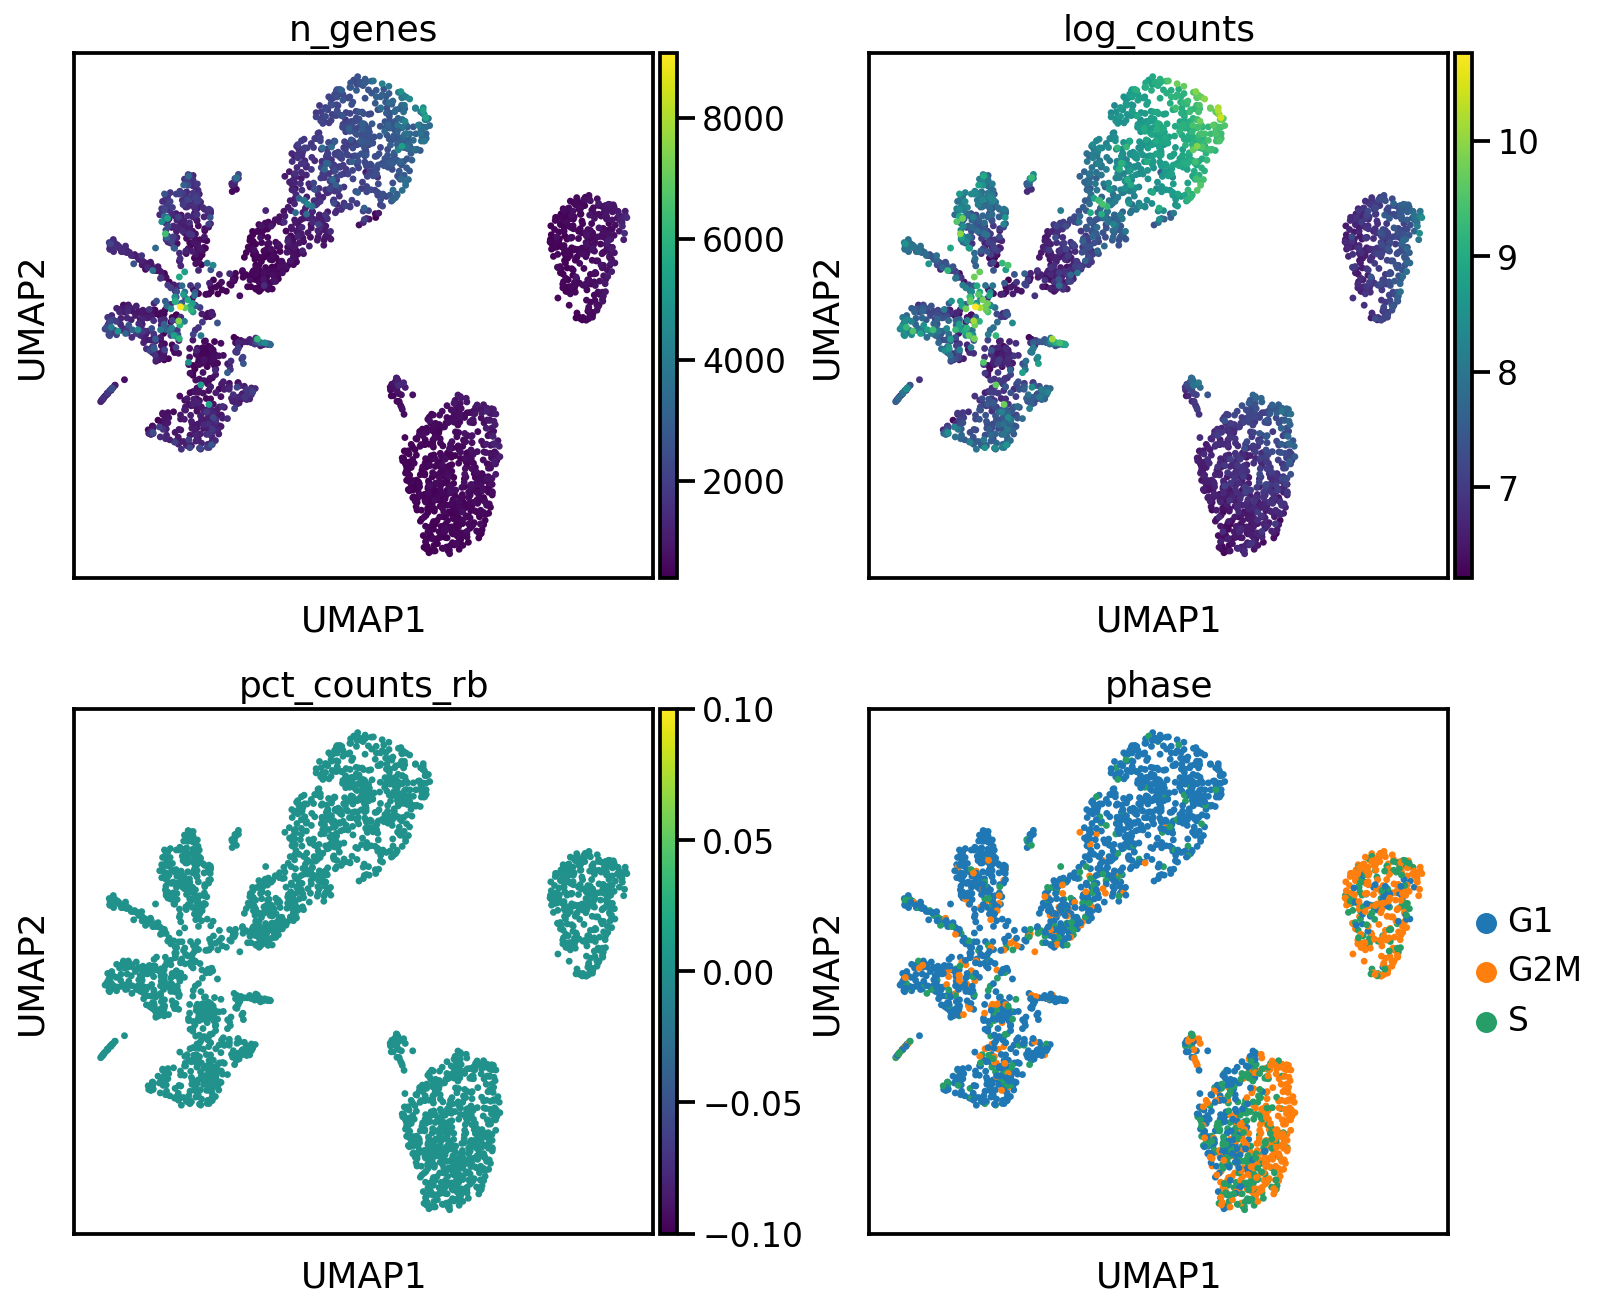

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
sc.pp.neighbors(adata, n_pcs=30,n_neighbors=15,random_state=42)

genes_to_plot = ['n_genes','log_counts','pct_counts_rb','phase']

sc.tl.umap(adata,random_state=42)
savefig=samplename+"_4_QC_doublets_vst_mito.pdf"
sc.pl.umap(adata,wspace=0.25, color = genes_to_plot,ncols=2,save=savefig)

In [ ]:
%%capture
sc.tl.leiden(adata,random_state=random_state,resolution=1.5, key_added='leiden_r1.5')
sc.tl.leiden(adata,random_state=random_state,resolution=1, key_added='leiden_r1')
sc.tl.leiden(adata,random_state=random_state, resolution=0.8, key_added='leiden_r0.8')
sc.tl.leiden(adata,random_state=random_state, resolution=0.5, key_added='leiden_r0.5')
sc.tl.leiden(adata,random_state=random_state, resolution=0.4, key_added='leiden_r0.4')
sc.tl.leiden(adata,random_state=random_state, resolution=0.3, key_added='leiden_r0.3')
sc.tl.leiden(adata,random_state=random_state, resolution=0.2, key_added='leiden_r0.2')

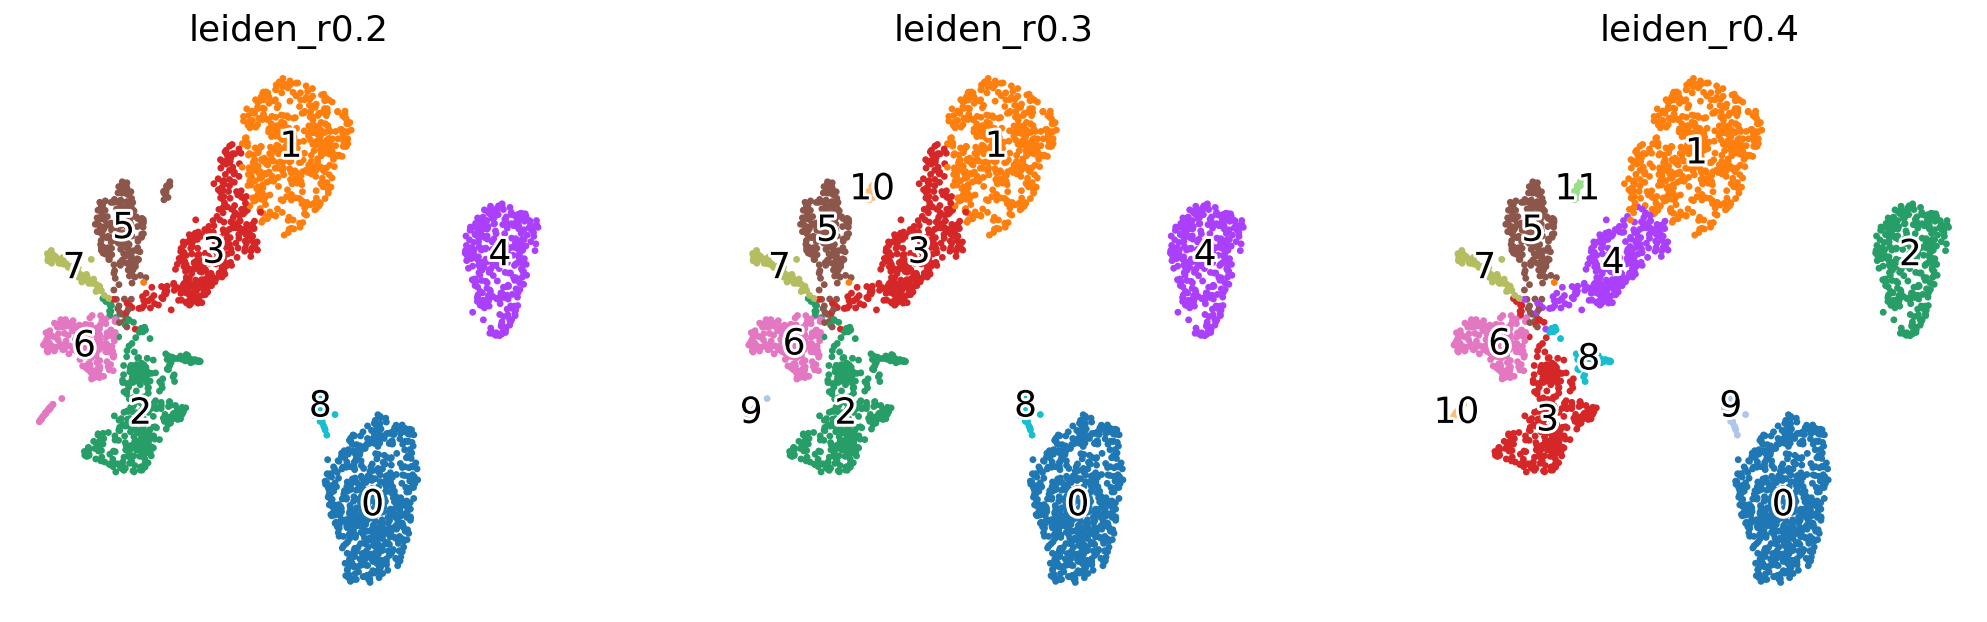

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_lores_vst.pdf"
sc.pl.umap(adata, color=['leiden_r0.2','leiden_r0.3','leiden_r0.4'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

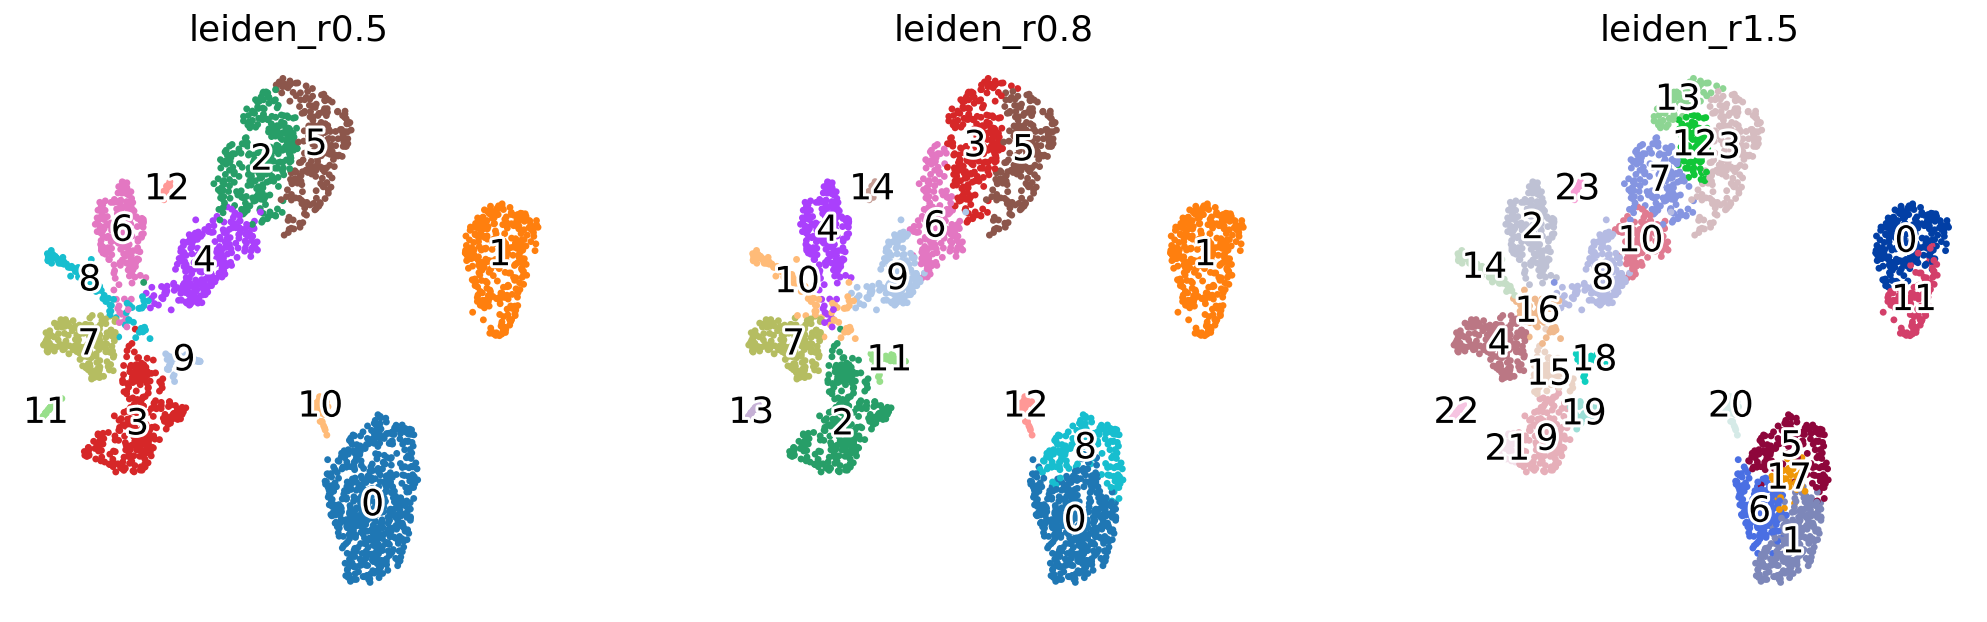

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_hires_vst.pdf"
sc.pl.umap(adata, color=['leiden_r0.5','leiden_r0.8','leiden_r1.5'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

If UMAP looks slightly less than perfect, we can use the following trick from the `scanpy` tutorial page:

In [ ]:
sc.tl.paga(adata,groups='leiden_r0.2')
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

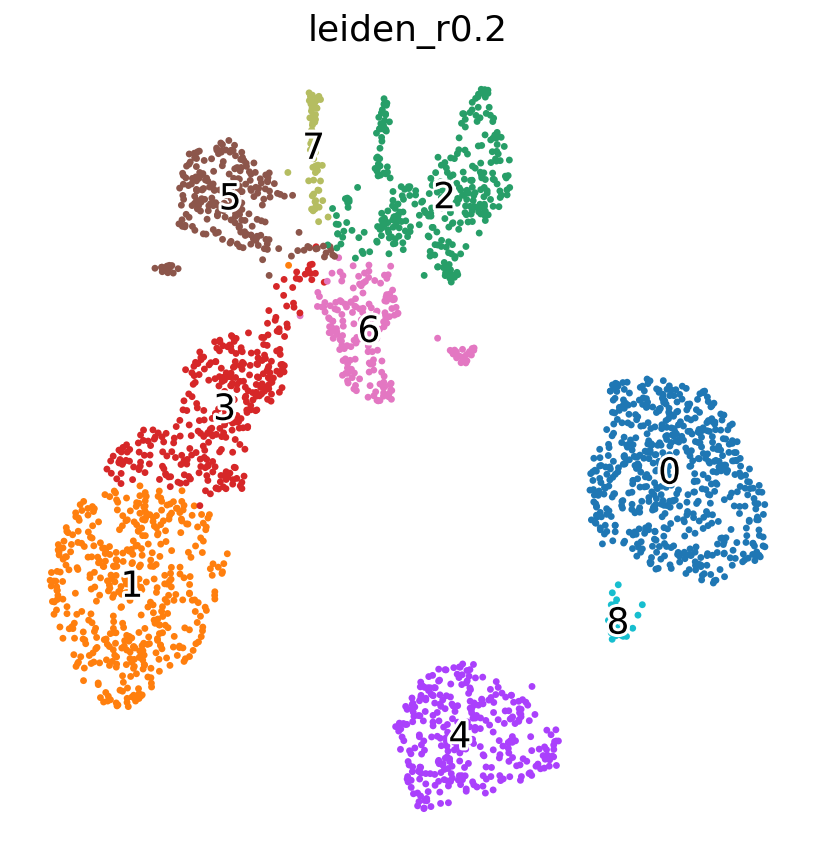

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(7,7)
savefig=samplename+"_5_clustering_vst_lowres.pdf"
sc.pl.umap(adata, color=['leiden_r0.2',],ncols=3, legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

# PART 4. Differential expression and marker selection.

After we have fixed the clusters, let's make gene markers using Wilcoxon test. Score plotting for each cluster allows to estimate the relative information of a marker in a quick fashion.

# Marker genes

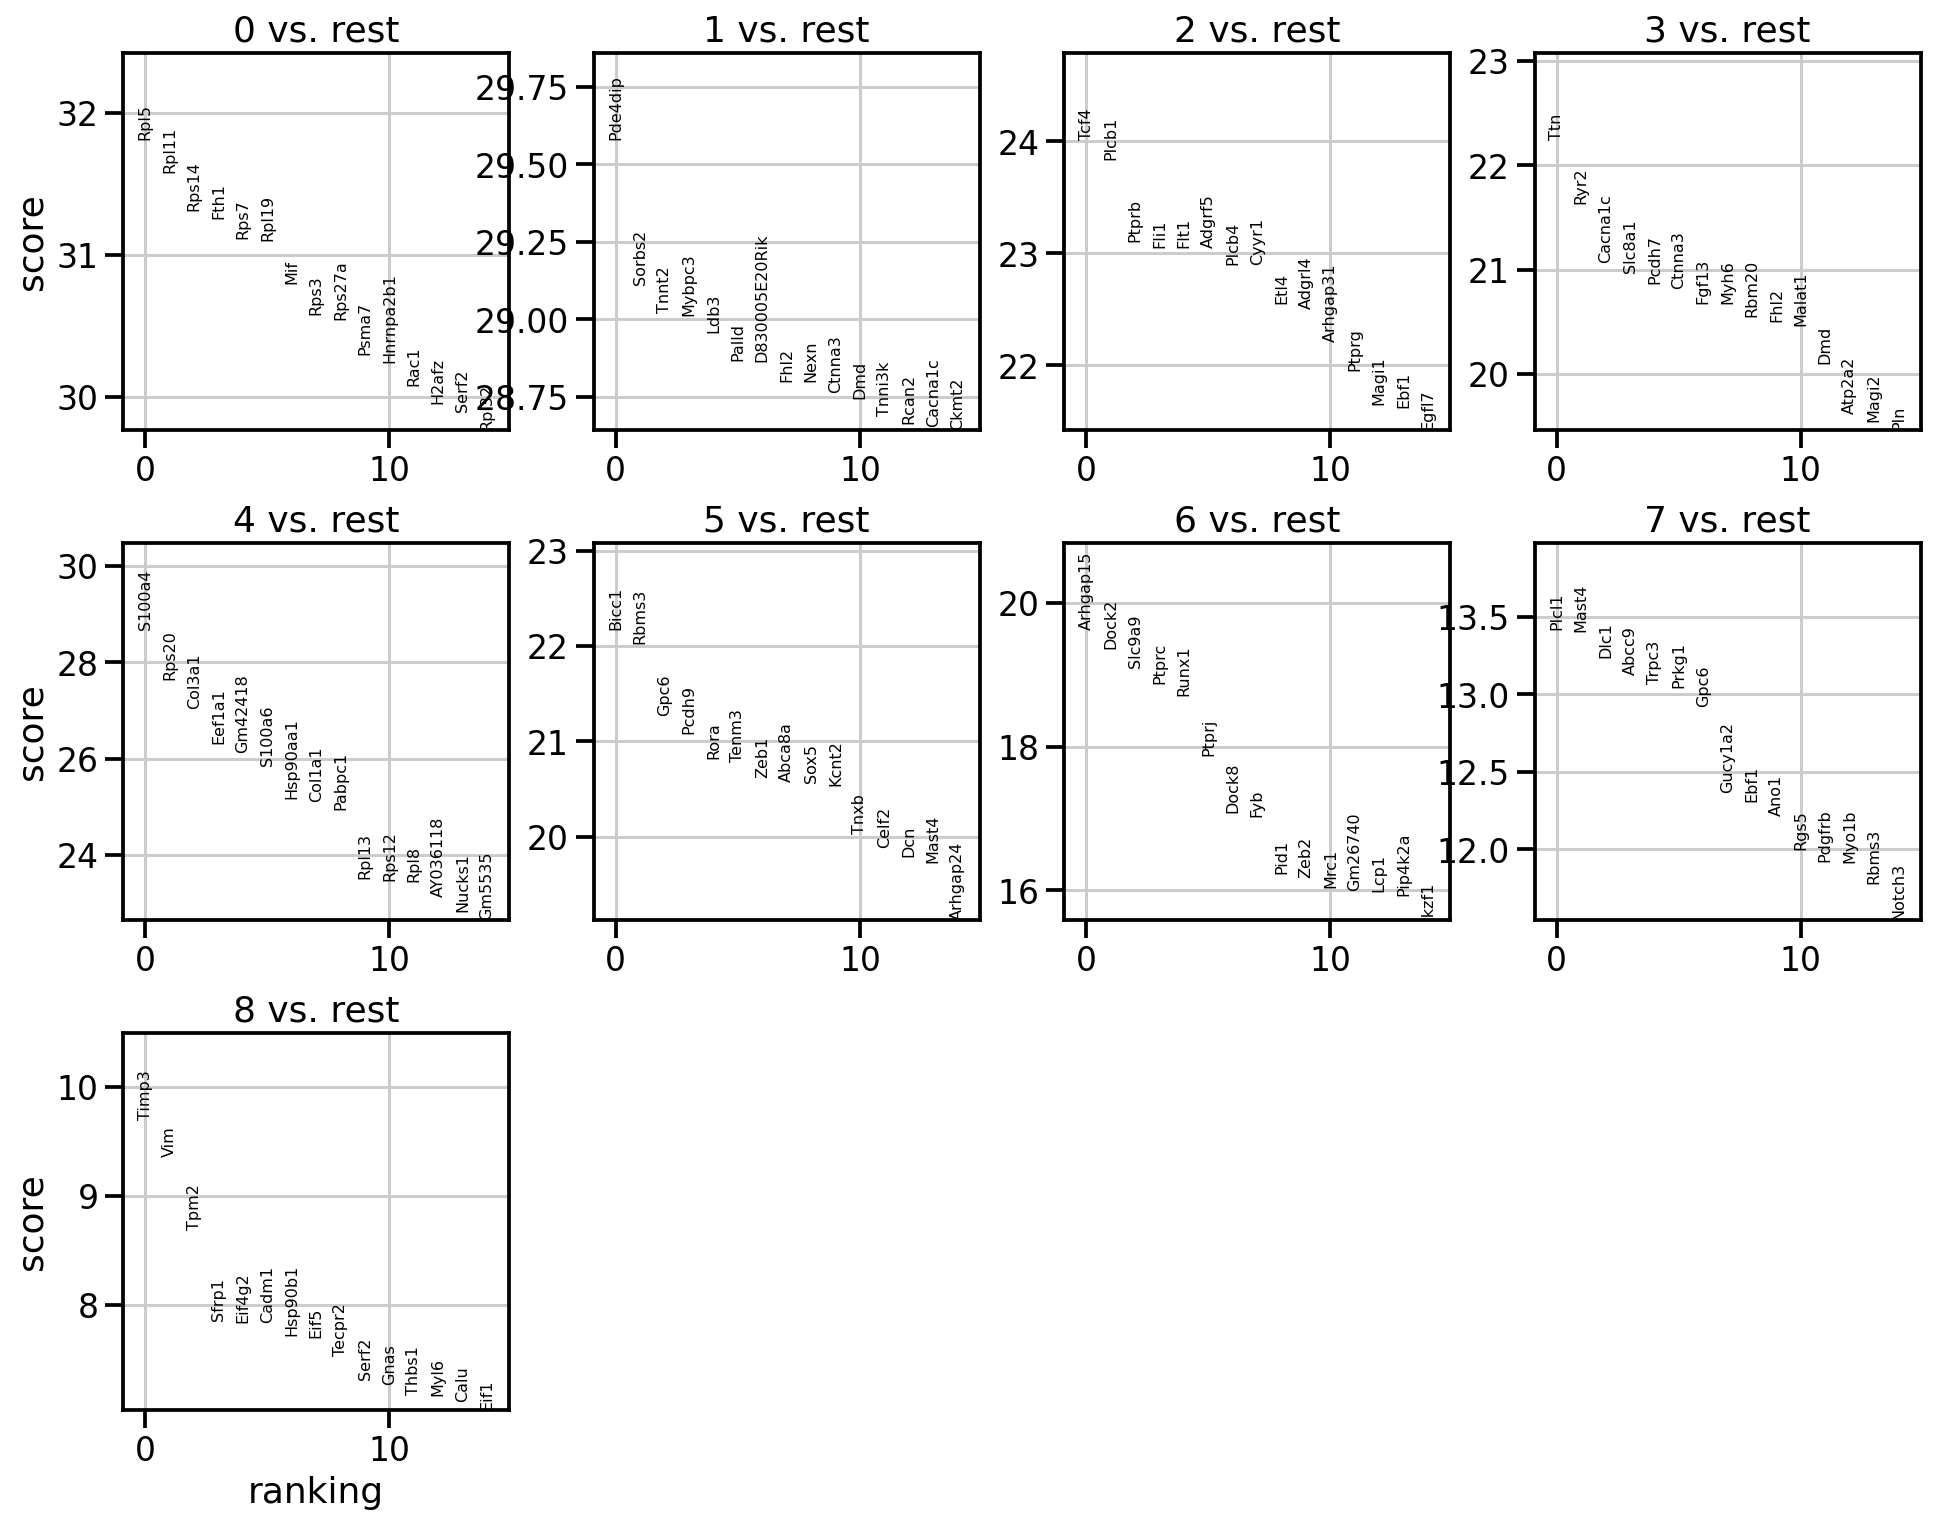

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(4,4)
sc.tl.rank_genes_groups(adata, 'leiden_r0.2', method='wilcoxon',layer='sqrt_norm',key_added = "wilcoxon",use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=15,key="wilcoxon", sharey=False)

lets get a table with the marker genes 

In [ ]:
#method : {‘logreg’, ‘t-test’, ‘wilcoxon’, ‘t-test_overestim_var’} | None (default: None)
sc.tl.rank_genes_groups(adata, 'leiden_r0.2', method='wilcoxon',n_genes=adata.shape[1],layer='sqrt_norm',key_added = "wilcoxon",use_raw=False)
markers=pd.DataFrame(adata.uns['wilcoxon']['names']).head(20)
markers

0              1         2        3         4         5  \
0        Rpl5        Pde4dip      Tcf4      Ttn    S100a4     Bicc1   
1       Rpl11         Sorbs2     Plcb1     Ryr2     Rps20     Rbms3   
2       Rps14          Tnnt2     Ptprb  Cacna1c    Col3a1      Gpc6   
3        Fth1         Mybpc3      Fli1   Slc8a1    Eef1a1     Pcdh9   
4        Rps7           Ldb3      Flt1    Pcdh7   Gm42418      Rora   
5       Rpl19          Palld    Adgrf5   Ctnna3    S100a6     Tenm3   
6         Mif  D830005E20Rik     Plcb4    Fgf13  Hsp90aa1      Zeb1   
7        Rps3           Fhl2     Cyyr1     Myh6    Col1a1    Abca8a   
8      Rps27a           Nexn      Etl4    Rbm20    Pabpc1      Sox5   
9       Psma7         Ctnna3    Adgrl4     Fhl2     Rpl13     Kcnt2   
10  Hnrnpa2b1            Dmd  Arhgap31   Malat1     Rps12      Tnxb   
11       Rac1         Tnni3k     Ptprg      Dmd      Rpl8     Celf2   
12      H2afz          Rcan2     Magi1   Atp2a2  AY036118       Dcn   
13      Serf2        Cacna1c      Ebf1    Magi2    Nucks1     Mast4   
14      Rpl32          Ckmt2     Egfl7      Pln    Gm5535  Arhgap24   
15     Nap1l1          Actn2    Pecam1    Palld     Rpl28  Mir100hg   
16      Rpl17          Coro6     Mecom    Esrrg     Rps23     Lama2   
17       Rps8          Rbm20     Dock9    Akap6     Rpl23    Plxdc2   
18      Rplp1          Myom1     Itpkb    Fhod3     Rack1      Egfr   
19      Rpl30           Trdn     Syne1    Tnnt2     Rpl12      Ebf2   

             6        7        8  
0     Arhgap15    Plcl1    Timp3  
1        Dock2    Mast4      Vim  
2       Slc9a9     Dlc1     Tpm2  
3        Ptprc    Abcc9    Sfrp1  
4        Runx1    Trpc3   Eif4g2  
5        Ptprj    Prkg1    Cadm1  
6        Dock8     Gpc6  Hsp90b1  
7          Fyb  Gucy1a2     Eif5  
8         Pid1     Ebf1   Tecpr2  
9         Zeb2     Ano1    Serf2  
10        Mrc1     Rgs5     Gnas  
11     Gm26740   Pdgfrb    Thbs1  
12        Lcp1    Myo1b     Myl6  
13     Pip4k2a    Rbms3     Calu  
14       Ikzf1   Notch3     Eif1  
15      Epsti1     Ebf2    Arpc2  
16        Rbpj     Rerg     Cfl1  
17       F13a1   Tbc1d1   Rpl18a  
18       Myo1f  Arhgap6     Pfn1  
19  AC149090.1    Pde8b    Calm2

In [ ]:
markers.to_csv('test.csv')

Lets visualize some markers genes

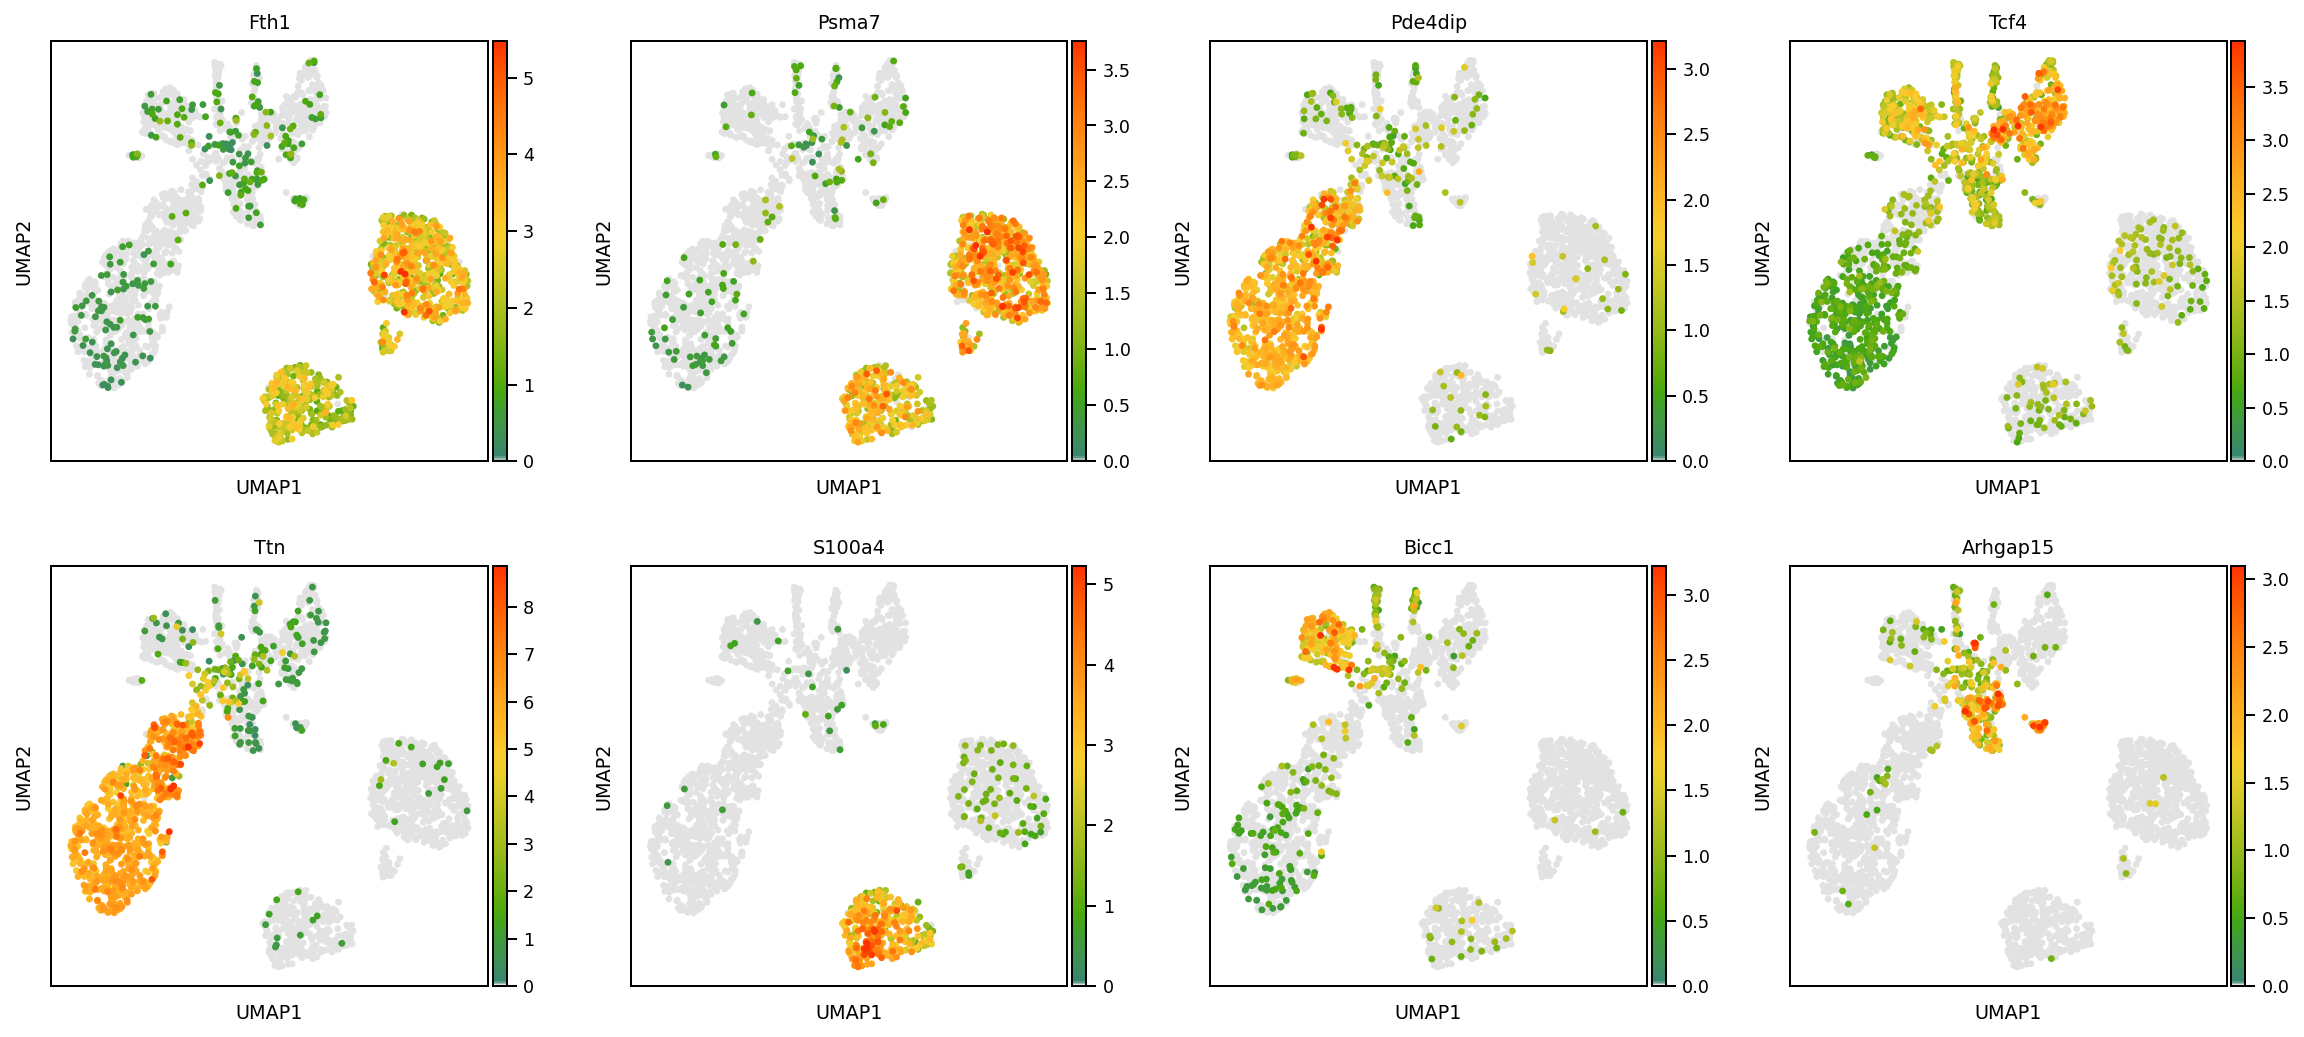

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(4,4) #rescale figures
savefig=samplename+"_10_markers_1.pdf"
sc.pl.umap(adata=adata, color=['Fth1','Psma7','Pde4dip','Tcf4','Ttn','S100a4','Bicc1','Arhgap15'],color_map=mymap,vmin='p20', vmax='p99.9',ncols=4,
           legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',use_raw=False,layer="sqrt_norm", save=savefig)

# Manual Annotation



 Using [panglaodb](https://panglaodb.se/search.html).  and other tools like [enrichR](https://maayanlab.cloud/Enrichr/) annotated the cluster

In [ ]:
adata.obs['annotated'] = adata.obs['leiden_r0.2'].cat.add_categories([ "Dendritic Cells"])
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['3','1'])] = 'Dendritic Cells'


adata.obs['annotated'] = adata.obs['annotated'].cat.remove_unused_categories()

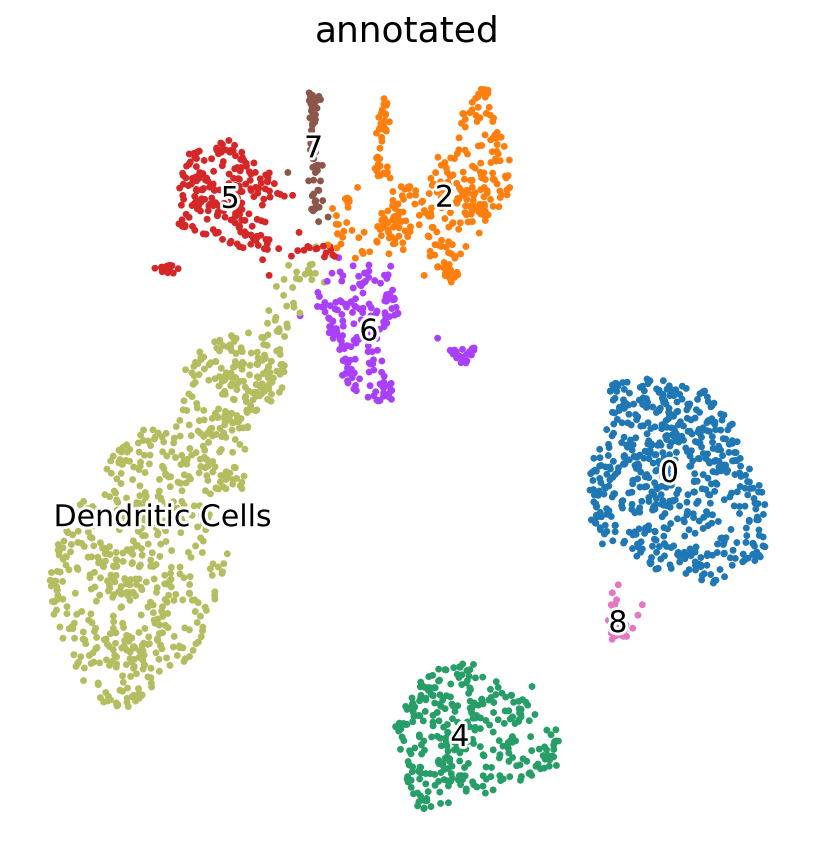

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(7,7)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_annotated_hires_annotated.pdf"
sc.pl.umap(adata, color=['annotated'], legend_loc='on data',cmap=mymap,legend_fontoutline=3,vmax='p99.9',legend_fontsize='small', legend_fontweight='normal',frameon=False,save=savefig)

#sample composition

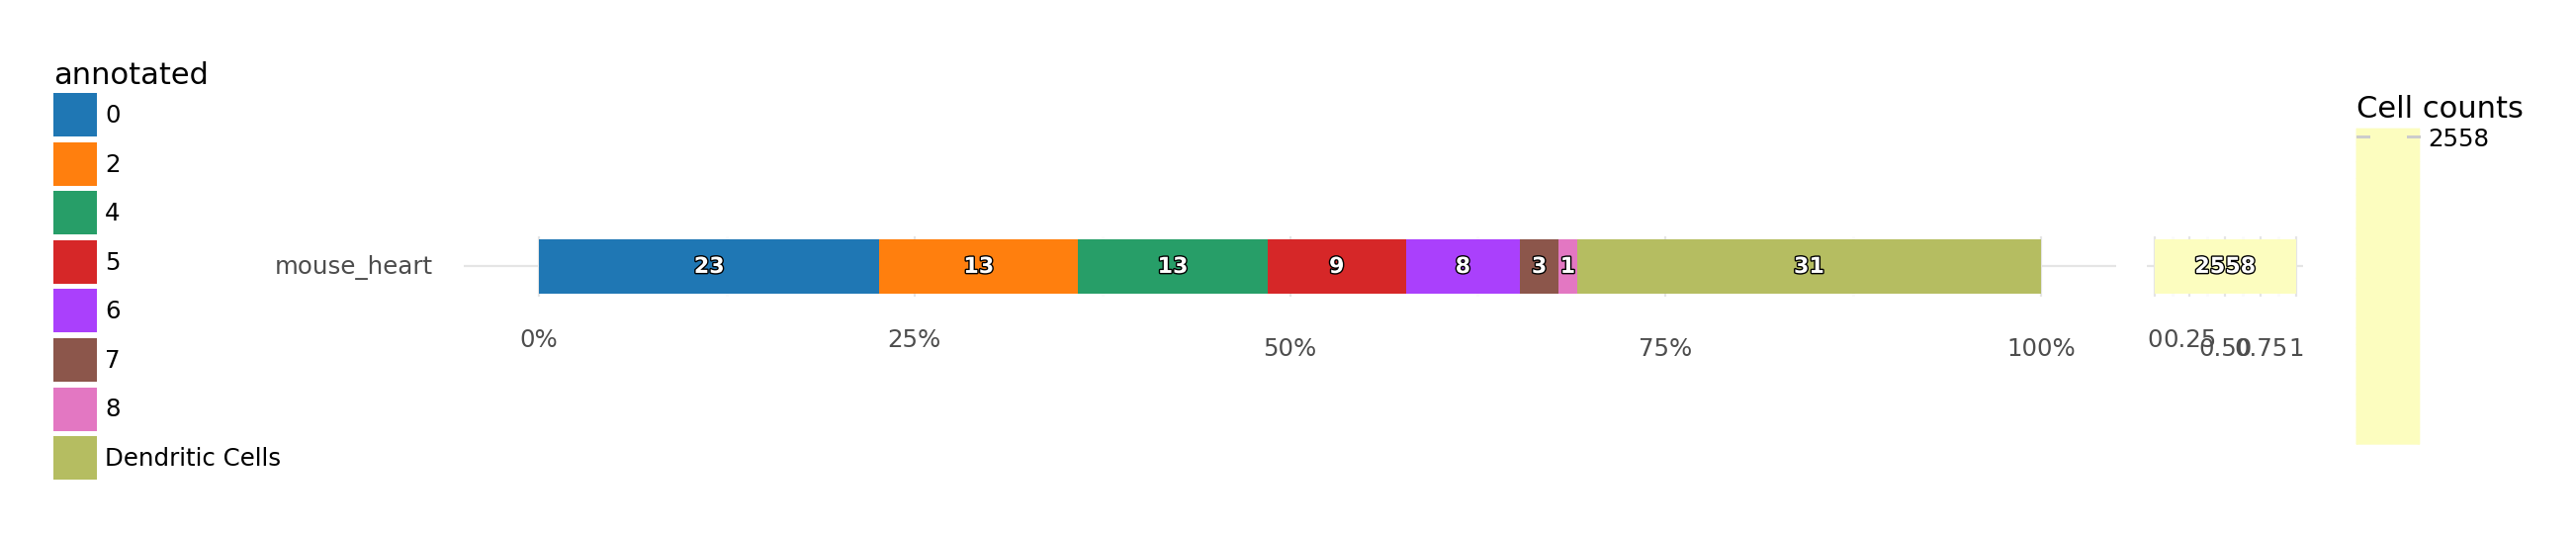

In [ ]:
 fig=plot_proportion_barplot_with_ncells(
    adata,
    'group',
    fill='annotated', 
    fill_breakdown=None,
    yaxis_label=None,
    fill_label='annotated',
    percent_limit=1., 
    show_percent=True,
    height_scale=1., 
    width_scale=1.,
    legend_position=(-0, 0.5),
    normalize_by=None,)
fig.savefig('cell_composition_by_FOV.pdf', dpi=300, bbox_inches='tight')

# PART 5. Gen Set Enrichment Analysis

Install gseapy using pip. Full documentation could be explored here [gseapy](https://gseapy.readthedocs.io/en/latest/introduction.html)

In [ ]:
!pip install gseapy pybiomart

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 38.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 KB 71.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 KB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 145.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.9/144.9 KB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 143.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 KB 46.6 MB/s eta 0:00:00
  Created wheel for bioservices: filename=bioservices-1.10.0-py3-none-any.whl size=230649 sha256=bc1f36a1ea1dd55696589969c0b5dcb0401795d48c8

In [ ]:
import gseapy
from gseapy.plot import barplot, dotplot

Creating directory /home/jovyan/.config/bioservices 


Selelct the species for the Gen set enrichment analysis

In [ ]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name('Mouse')#choose btw sps 
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease_Perturbations_from_GEO_up', 'Disease_Signatures

re-run rank_genes for the propper annotation label

In [ ]:
#sc.tl.rank_genes_groups(cdata, 'treatmentcondition', method='t-test' ,key_added = "wilcoxon",layer='sct_corrected',use_raw=False)
sc.tl.rank_genes_groups(adata, 'leiden_r0.2', method='t-test' ,key_added = "wilcoxon",use_raw=False,layer='sqrt_norm')

Filter marker genes by adj p value and Fold change 

In [ ]:
# the analysis is done dataset  at the time, so you can select 1 cluster or 1 contrast. 
#here I'm selecting cluster 2, taking genes with adj pvalue<0.05 and log2fc>2


glist=sc.get.rank_genes_groups_df(adata, group='2', key='wilcoxon',log2fc_min=2,pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
print(len(glist))

929


Run enrichr using the list of genes in "glist". 

Select the geneset from the gene_set_names

In [ ]:
enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Mouse',
                     gene_sets='WikiPathways_2019_Mouse',
                     description='pathway',
                     cutoff = 0.05)

In [ ]:
enr_res.results.head(10)



Gene_set                                               Term  \
0  WikiPathways_2019_Mouse  Focal Adhesion-PI3K-Akt-mTOR-signaling pathway...   
1  WikiPathways_2019_Mouse  Primary Focal Segmental Glomerulosclerosis FSG...   
2  WikiPathways_2019_Mouse                         Id Signaling Pathway WP512   
3  WikiPathways_2019_Mouse              White fat cell differentiation WP2872   
4  WikiPathways_2019_Mouse                          Spinal Cord Injury WP2432   
5  WikiPathways_2019_Mouse                                Focal Adhesion WP85   
6  WikiPathways_2019_Mouse  BMP Signaling Pathway in Eyelid Development WP...   
7  WikiPathways_2019_Mouse           Signal Transduction of S1P Receptor WP57   
8  WikiPathways_2019_Mouse           Hfe effect on hepcidin production WP3673   
9  WikiPathways_2019_Mouse                Delta-Notch Signaling Pathway WP265   

  Overlap   P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  34/324  0.000008          0.001039            0                     0   
1   12/72  0.000110          0.006769            0                     0   
2    9/51  0.000507          0.016201            0                     0   
3    7/32  0.000553          0.016201            0                     0   
4   13/99  0.000659          0.016201            0                     0   
5  19/185  0.001022          0.020948            0                     0   
6    5/20  0.001850          0.032506            0                     0   
7    5/22  0.002909          0.041511            0                     0   
8     3/7  0.003037          0.041511            0                     0   
9   10/83  0.005025          0.061806            0                     0   

   Odds Ratio  Combined Score  \
0    2.460235       28.740014   
1    4.146347       37.791671   
2    4.432220       33.623588   
3    5.784035       43.377068   
4    3.132997       22.950505   
5    2.377830       16.374047   
6    6.874459       43.258214   
7    6.065062       35.419487   
8   15.443035       89.519665   
9    2.831845       14.989976   

                                               Genes  
0  FLT1;EPAS1;ITGB4;FLT4;LAMA4;LAMA3;PDGFB;IL4RA;...  
1  CDKN1C;KIRREL3;MYO1E;INF2;NOTCH1;ITGB4;PODXL;W...  
2      ACVRL1;ELK4;SMAD1;FLT1;ID1;KDR;PAX5;BMP6;ELK3  
3            ZFP423;MECOM;EBF1;PPARG;GATA2;KLF4;KLF2  
4  SEMA6A;NOS2;IL1R1;TNFSF13;KLK8;ICAM1;RHOB;EFNB...  
5  FLT1;VWF;CAV2;ITGB4;CAV1;LAMA4;LAMA3;PDGFB;VEG...  
6                      SMAD1;FOXC1;NOTCH1;TGFA;MAPK3  
7                      ASAH2;AKT3;S1PR1;MAPK12;MAPK3  
8                                     ID1;BMP6;SMAD7  
9  DLL4;JAG2;SMAD1;NOTCH1;MAML2;HEY1;MFNG;NOTCH4;...

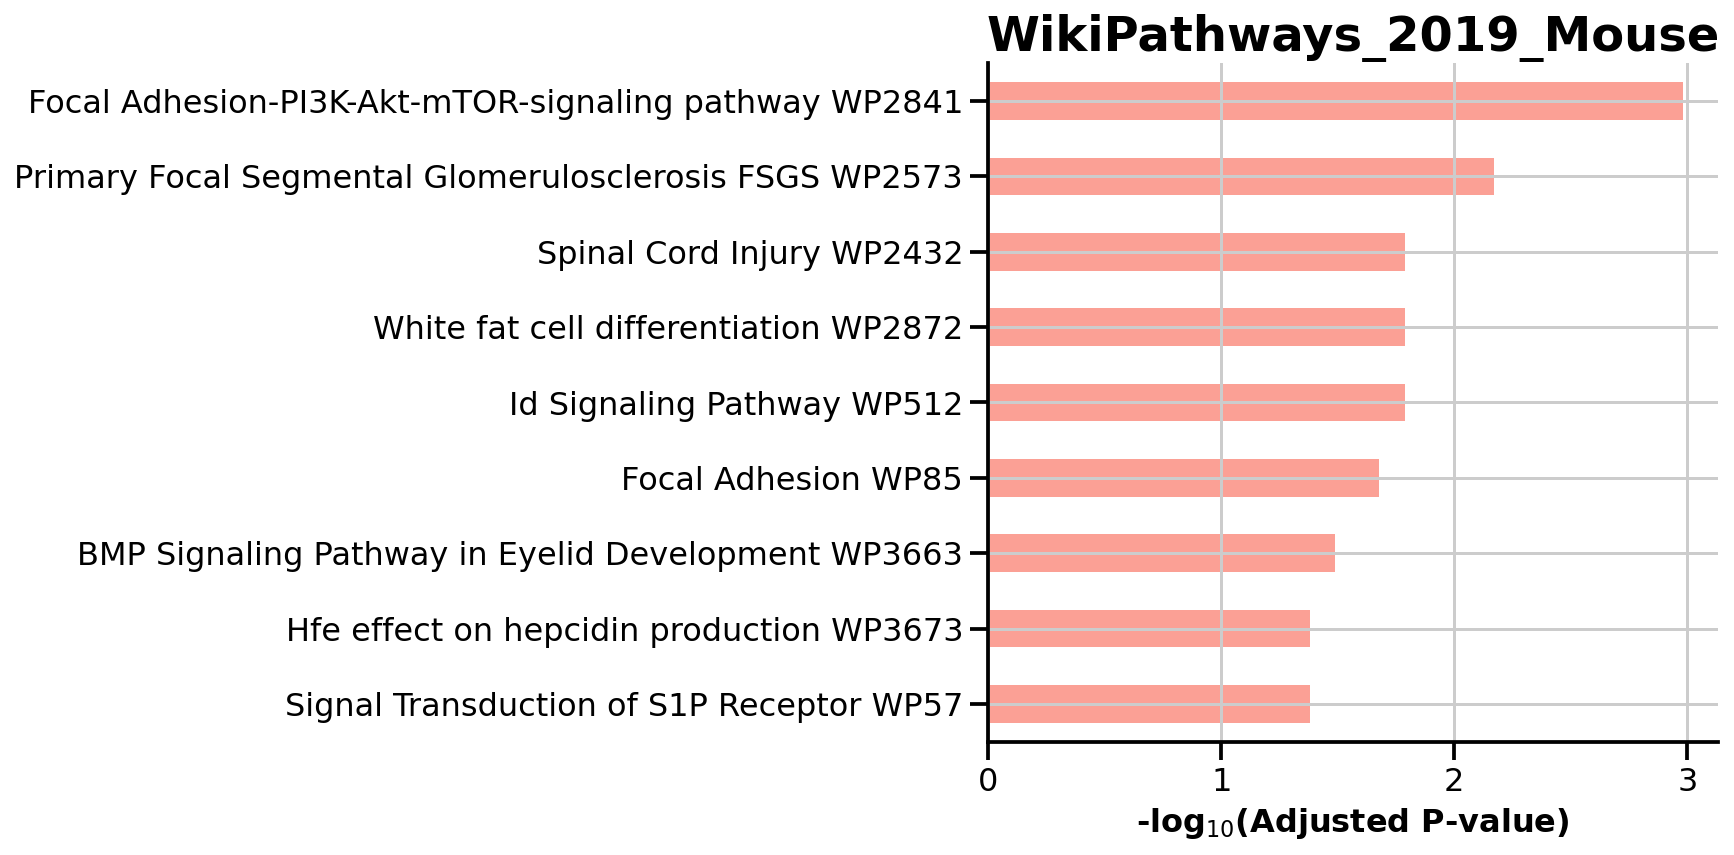

In [ ]:
gseapy.barplot(enr_res.res2d,title='WikiPathways_2019_Mouse',save='WikiPathways_2019_Mouse')

<AxesSubplot:title={'center':'WikiPathways_2019_Mouse'}, xlabel='-log$_{10}$(Adjusted P-value)'>

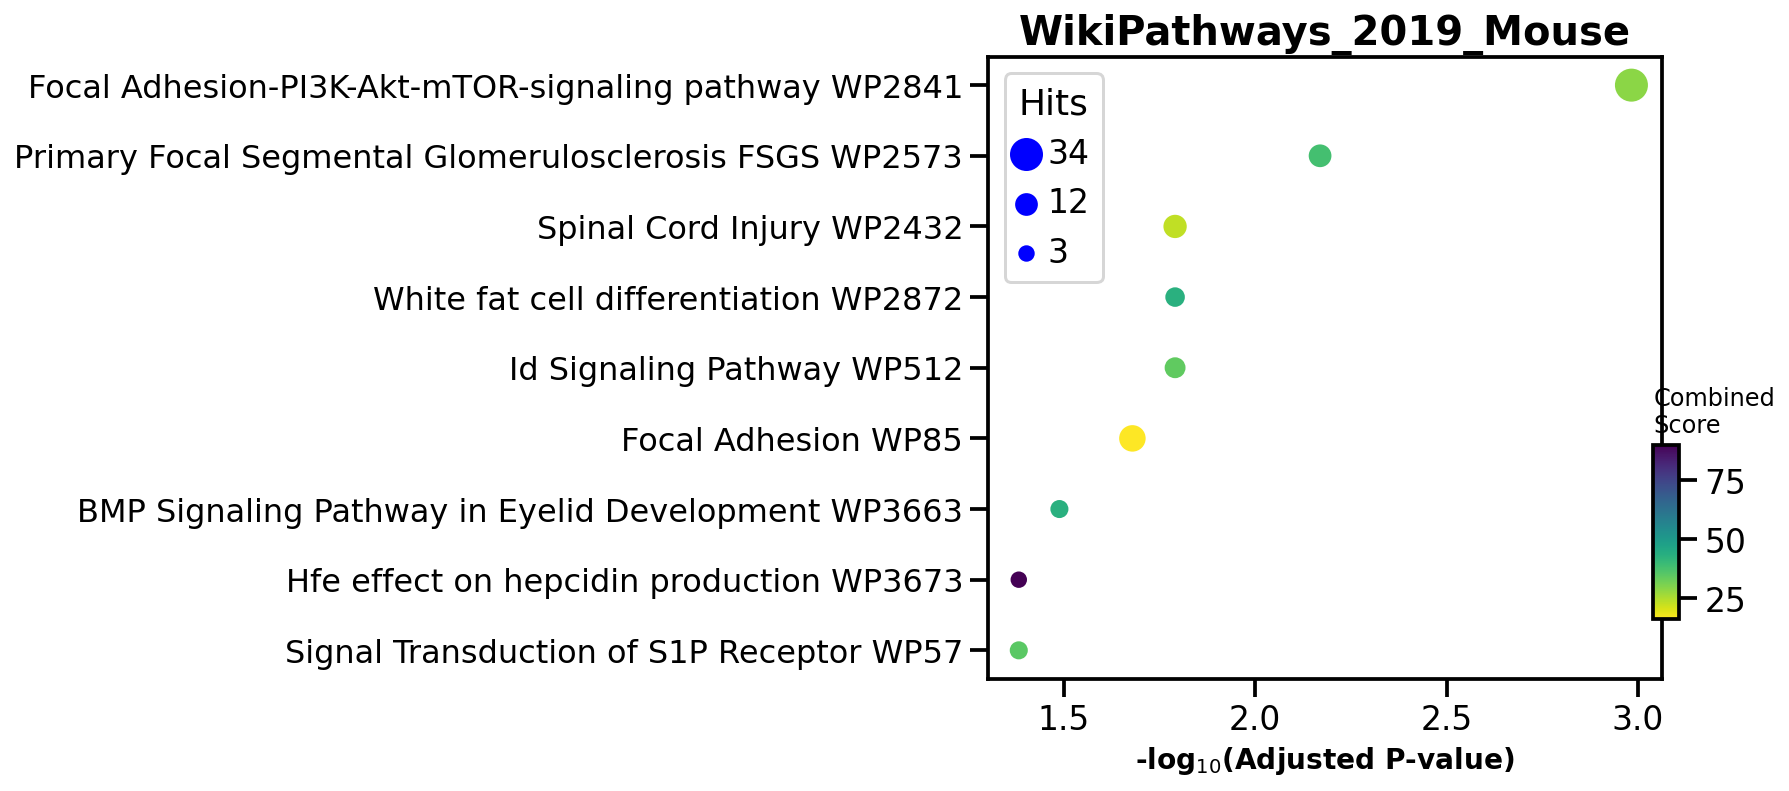

In [ ]:
dotplot(enr_res.res2d, title='WikiPathways_2019_Mouse',cmap='viridis_r')

In [ ]:
Geneset='Azimuth_Cell_Types_2021'

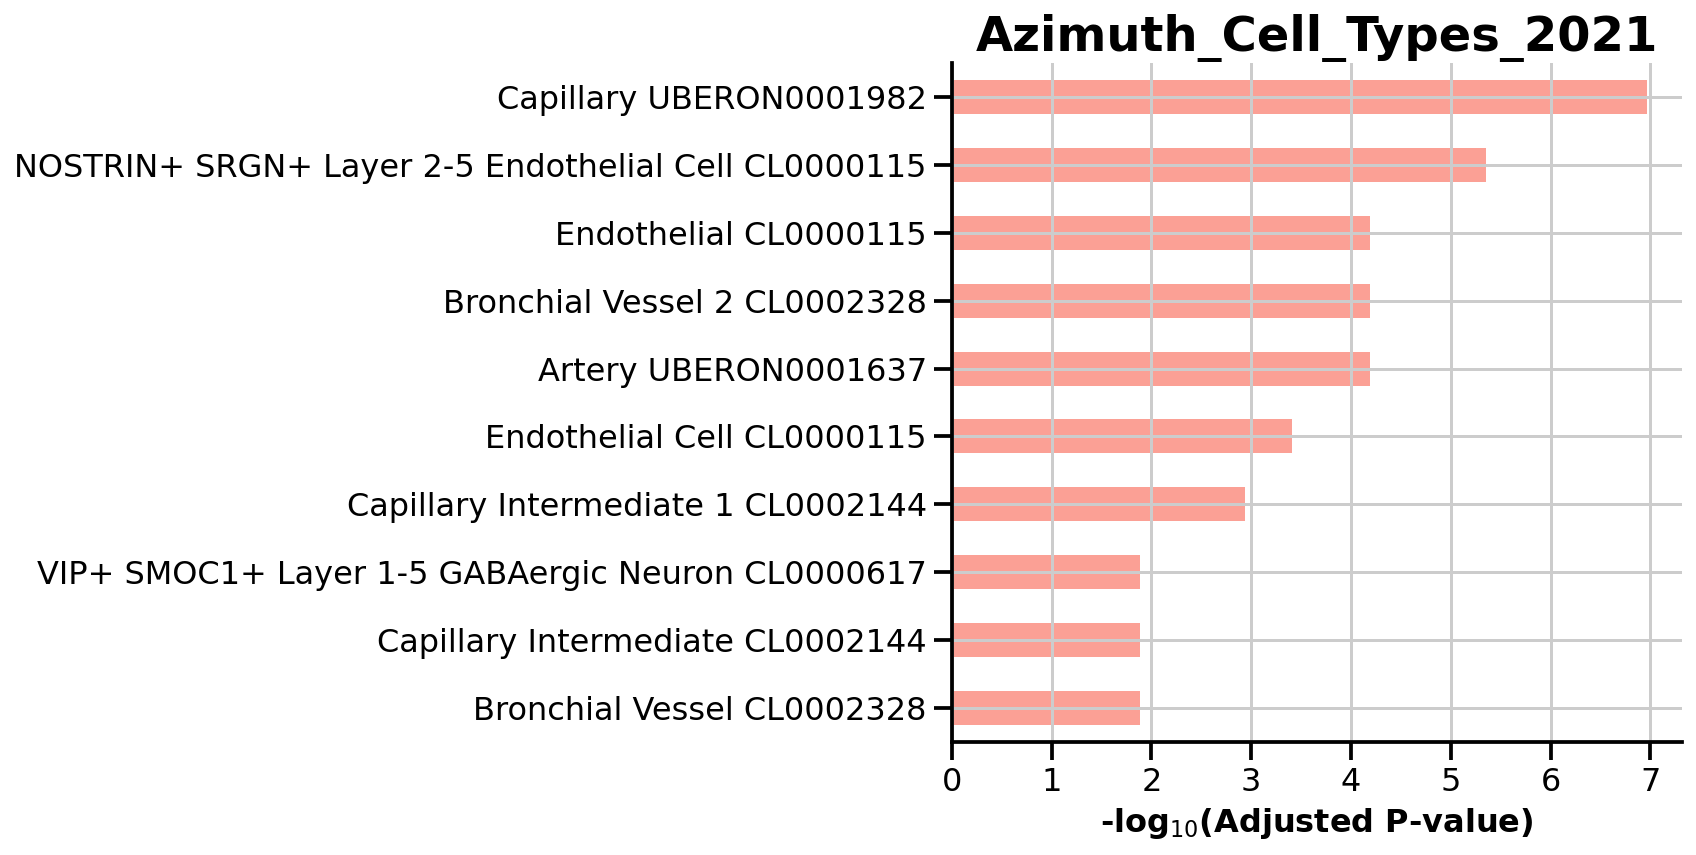

In [ ]:
enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Mouse',
                     gene_sets=Geneset,
                     description='pathway',
                     cutoff = 0.5)
gseapy.barplot(enr_res.res2d,title=Geneset,save=Geneset)

In [ ]:
glist=sc.get.rank_genes_groups_df(adata, group='3', key='wilcoxon',log2fc_min=2,pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
print(len(glist))

95


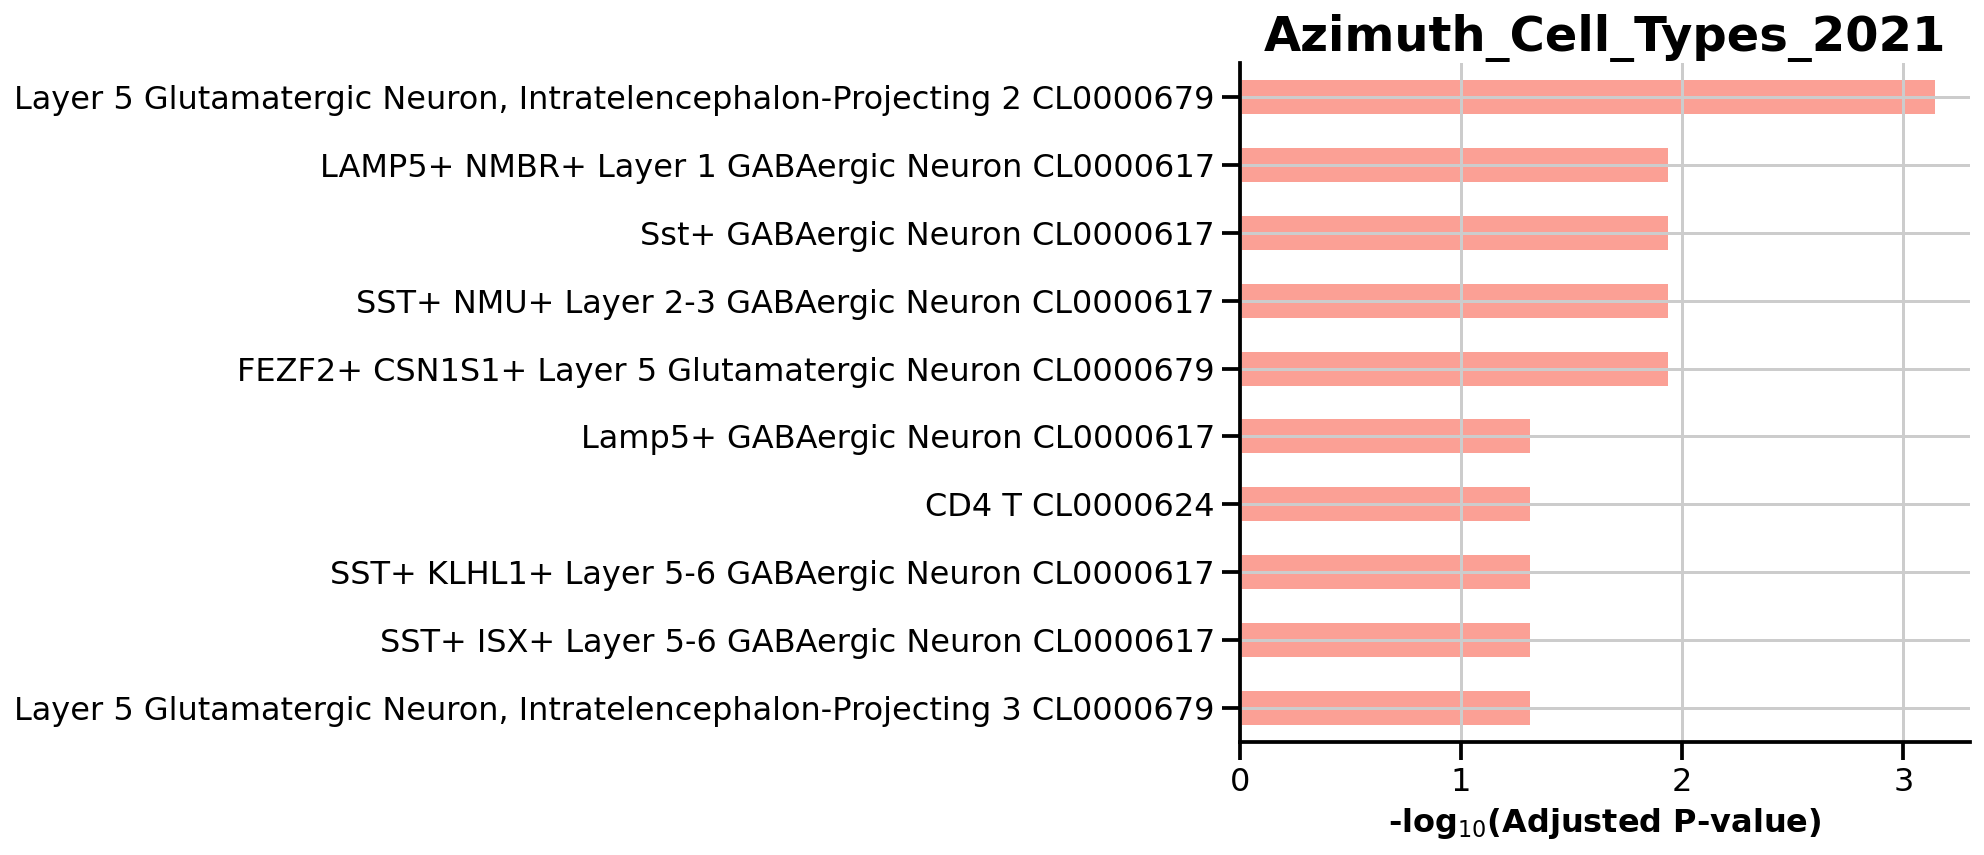

In [ ]:
enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Mouse',
                     gene_sets=Geneset,
                     description='pathway',
                     cutoff = 0.5)
gseapy.barplot(enr_res.res2d,title=Geneset,save=Geneset)

# PART 6.Automatic cell annotattion using scoreCT

In [ ]:
! git clone https://github.com/LucasESBS/scoreCT

fatal: destination path 'scoreCT' already exists and is not an empty directory.


In [ ]:
import scorect as ct

In [ ]:
# Load reference table - scoreCT api provides a wrapper for gmt, tsv and csv formats.
######annotated from paper/ your own db 
ref_marker = ct.read_markers_from_file('/home/jovyan/work/test.csv')

In [ ]:
ref_marker

0              1         2        3         4         5  \
0        Rpl5        Pde4dip      Tcf4      Ttn    S100a4     Bicc1   
1       Rpl11         Sorbs2     Plcb1     Ryr2     Rps20     Rbms3   
2       Rps14          Tnnt2     Ptprb  Cacna1c    Col3a1      Gpc6   
3        Fth1         Mybpc3      Fli1   Slc8a1    Eef1a1     Pcdh9   
4        Rps7           Ldb3      Flt1    Pcdh7   Gm42418      Rora   
5       Rpl19          Palld    Adgrf5   Ctnna3    S100a6     Tenm3   
6         Mif  D830005E20Rik     Plcb4    Fgf13  Hsp90aa1      Zeb1   
7        Rps3           Fhl2     Cyyr1     Myh6    Col1a1    Abca8a   
8      Rps27a           Nexn      Etl4    Rbm20    Pabpc1      Sox5   
9       Psma7         Ctnna3    Adgrl4     Fhl2     Rpl13     Kcnt2   
10  Hnrnpa2b1            Dmd  Arhgap31   Malat1     Rps12      Tnxb   
11       Rac1         Tnni3k     Ptprg      Dmd      Rpl8     Celf2   
12      H2afz          Rcan2     Magi1   Atp2a2  AY036118       Dcn   
13      Serf2        Cacna1c      Ebf1    Magi2    Nucks1     Mast4   
14      Rpl32          Ckmt2     Egfl7      Pln    Gm5535  Arhgap24   
15     Nap1l1          Actn2    Pecam1    Palld     Rpl28  Mir100hg   
16      Rpl17          Coro6     Mecom    Esrrg     Rps23     Lama2   
17       Rps8          Rbm20     Dock9    Akap6     Rpl23    Plxdc2   
18      Rplp1          Myom1     Itpkb    Fhod3     Rack1      Egfr   
19      Rpl30           Trdn     Syne1    Tnnt2     Rpl12      Ebf2   

             6        7        8  
0     Arhgap15    Plcl1    Timp3  
1        Dock2    Mast4      Vim  
2       Slc9a9     Dlc1     Tpm2  
3        Ptprc    Abcc9    Sfrp1  
4        Runx1    Trpc3   Eif4g2  
5        Ptprj    Prkg1    Cadm1  
6        Dock8     Gpc6  Hsp90b1  
7          Fyb  Gucy1a2     Eif5  
8         Pid1     Ebf1   Tecpr2  
9         Zeb2     Ano1    Serf2  
10        Mrc1     Rgs5     Gnas  
11     Gm26740   Pdgfrb    Thbs1  
12        Lcp1    Myo1b     Myl6  
13     Pip4k2a    Rbms3     Calu  
14       Ikzf1   Notch3     Eif1  
15      Epsti1     Ebf2    Arpc2  
16        Rbpj     Rerg     Cfl1  
17       F13a1   Tbc1d1   Rpl18a  
18       Myo1f  Arhgap6     Pfn1  
19  AC149090.1    Pde8b    Calm2

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.2', n_genes=len(adata.raw.var), use_raw=True)

In [ ]:
# Wrangle results from existing sc.tl.rank_genes_groups() results
# Let's have a look for cluster 0
marker_df = ct.wrangle_ranks_from_anndata(adata)
print(marker_df.head())

Wrangling: Number of markers used in ranked_gene_groups:  16339
Wrangling: Groups used for ranking: leiden_r0.2
     z_score      adj_pvals   gene cluster_number
0  28.079754  2.647366e-114   Rpl5              0
1  27.834929  2.306829e-116  Rpl11              0
2  27.684465  1.732818e-119  Rpl19              0
3  27.582108  2.343723e-114   Rps7              0
4  26.982109  7.043458e-115   Rps3              0


In [ ]:
# Score cell types for each cluster 
# Let's set parameters first - K represents the number of genes included in the ranking
# m represents the number of bins used to divide the top K genes.
K = 300
m = 5
# Get the background genes - here, all the genes used to run the differential gene expression test
background = adata.raw.var.index.tolist()
# Now run the function
ct_pval, ct_score = ct.celltype_scores(nb_bins=m,
                                        ranked_genes=marker_df,
                                        K_top = K,
                                        marker_ref=ref_marker,
                                        background_genes=background,
                                        null_model='multinomial')

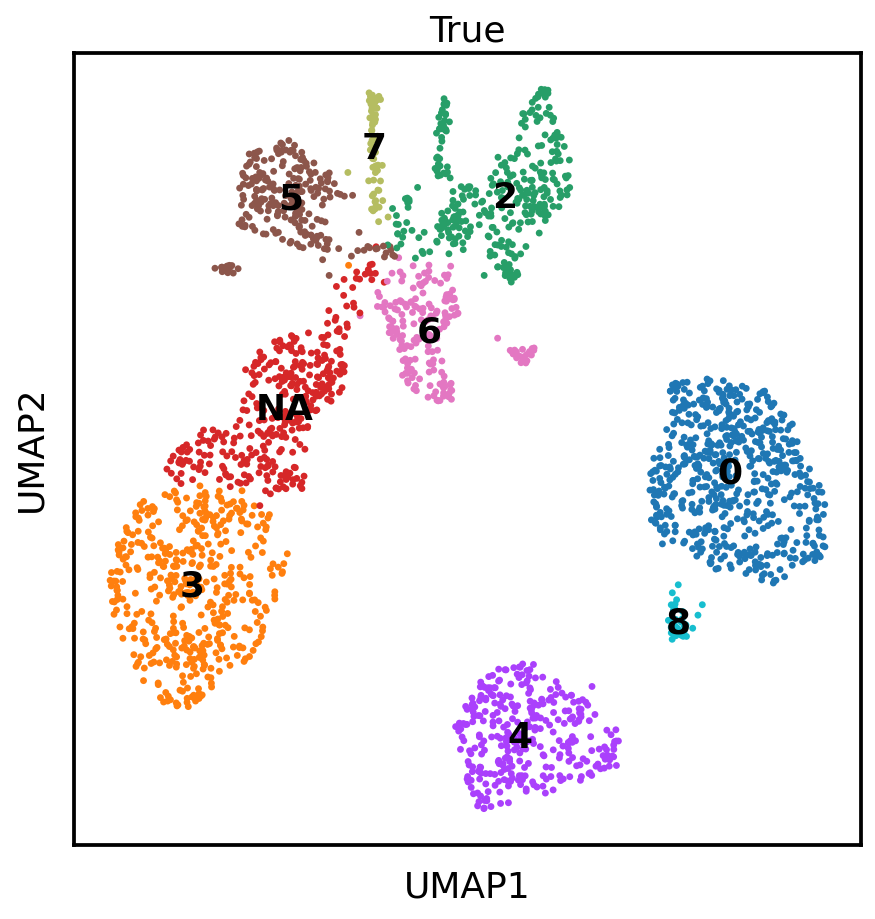

In [ ]:
# Now assign clusters to cell types
cluster_assign = adata.obs['leiden_r0.2']
celltype_assign = ct.assign_celltypes(cluster_assignment=cluster_assign, ct_pval_df=ct_pval, ct_score_df=ct_score, cutoff=0.1)
# Add to anndata object
adata.obs['scorect'] = celltype_assign
# Let's compare with the true assignment now! 
sc.pl.umap(adata, color=['scorect'], legend_loc="on data", title=['True','Predicted'], cmap='Set2', wspace=0.33)

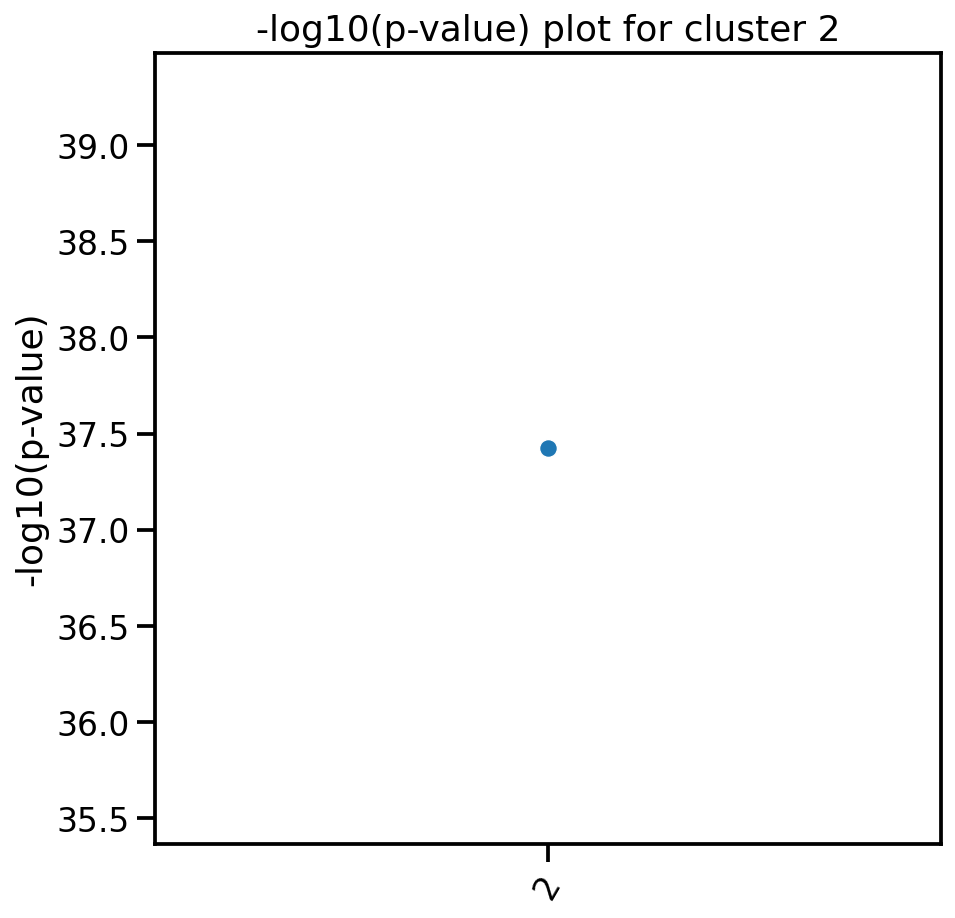

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


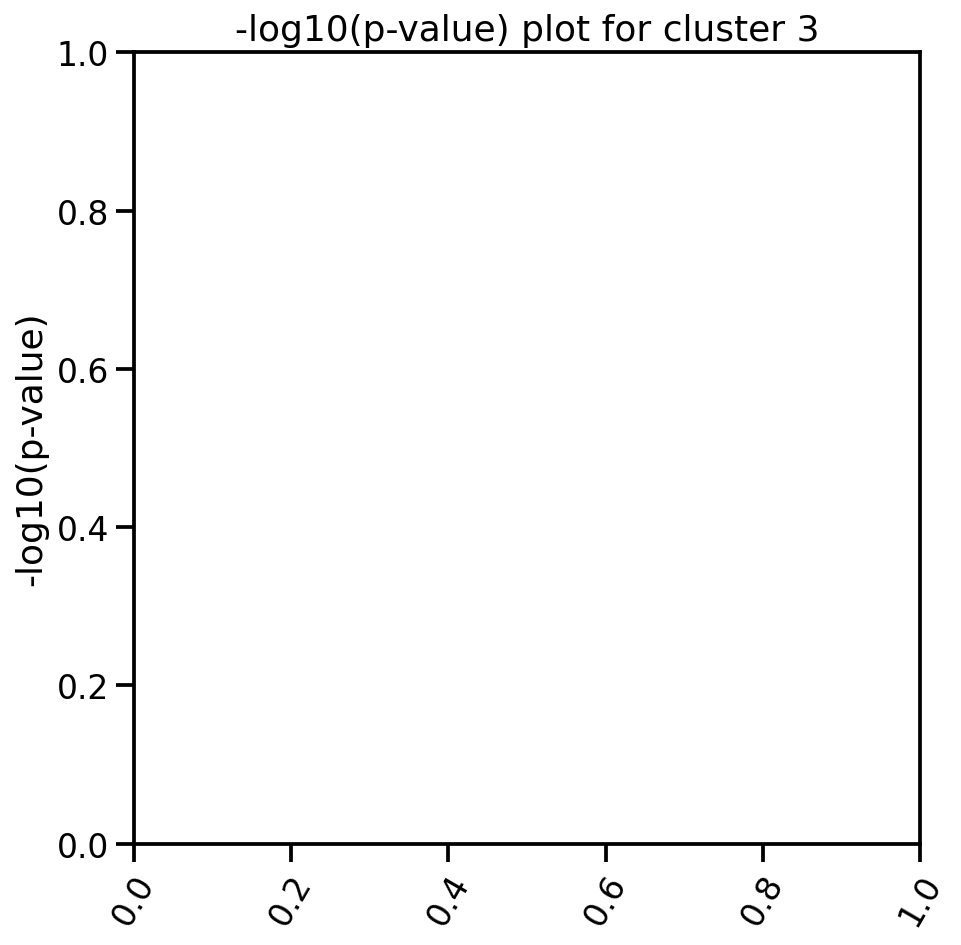

In [ ]:
# Let's have a look at the pvalue for clusters 0 and 1
ct.plot_pvalue(ct_pval, clusters=['2','3'], n_types=3)

# save the annotated h5ad object

In [ ]:
adata.write(samplename+'_'+ yourname +'_'+ 'annotated.h5ad')